# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import argparse
import glob
import sys 
import yaml 
import glob
import h5py 
import ray
import logging 
import json
import gc
import cv2
import time
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
# import io_dict_to_hdf5 as ioh5
import xarray as xr
import scipy.linalg as linalg
import scipy.sparse as sparse
import matplotlib.gridspec as gridspec

from tqdm.notebook import tqdm, trange
from matplotlib.backends.backend_pdf import PdfPages
from scipy import signal
from pathlib import Path
from scipy.optimize import minimize_scalar,minimize
from scipy.interpolate import interp1d
from scipy.ndimage import shift as imshift
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn import linear_model as lm 
from scipy.stats import binned_statistic
from sklearn.utils import shuffle
from sklearn.metrics import r2_score, mean_poisson_deviance
from pyglmnet import GLMCV, GLM

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sys.path.append(str(Path('.').absolute()))
from utils import *
import io_dict_to_hdf5 as ioh5
from format_data import load_ephys_data_aligned

pd.set_option('display.max_rows', None)
FigPath = check_path(Path('~/Research/SensoryMotorPred_Data').expanduser(),'Figures/Encoding')

ray.init(
    ignore_reinit_error=True,
    logging_level=logging.ERROR,
)
# print(f'Dashboard URL: http://{ray.get_dashboard_url()}')
# print('Dashboard URL: http://localhost:{}'.format(ray.get_dashboard_url().split(':')[-1]))

{'node_ip_address': '184.171.84.86',
 'raylet_ip_address': '184.171.84.86',
 'redis_address': '184.171.84.86:6379',
 'object_store_address': '/tmp/ray/session_2021-10-12_09-18-14_822175_259382/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-10-12_09-18-14_822175_259382/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-10-12_09-18-14_822175_259382',
 'metrics_export_port': 57132,
 'node_id': 'f7e5bf7df30a19d8f7525741882523920ac0da0584d5c792adbb6a9f'}

# Gather Data

In [2]:
def load_train_test(file_dict, save_dir, model_dt=.1, frac=.1, train_size=.7, do_shuffle=False, do_norm=False, free_move=True, has_imu=True, has_mouse=False,):
    ##### Load in preprocessed data #####
    data = load_ephys_data_aligned(file_dict, save_dir, model_dt=model_dt, free_move=free_move, has_imu=has_imu, has_mouse=has_mouse,)
    if free_move:
        ##### Find 'good' timepoints when mouse is active #####
        nan_idxs = []
        for key in data.keys():
            nan_idxs.append(np.where(np.isnan(data[key]))[0])
        good_idxs = np.ones(len(data['model_active']),dtype=bool)
        good_idxs[data['model_active']<.5] = False
        good_idxs[np.unique(np.hstack(nan_idxs))] = False
    else:
        good_idxs = np.where((np.abs(data['model_th'])<10) & (np.abs(data['model_phi'])<10))[0]
    
    data['raw_nsp'] = data['model_nsp'].copy()
    ##### return only active data #####
    for key in data.keys():
        if (key != 'model_nsp') & (key != 'model_active') & (key != 'unit_nums'):
            data[key] = data[key][good_idxs] # interp_nans(data[key]).astype(float)
        elif (key == 'model_nsp'):
            data[key] = data[key][good_idxs]
        elif (key == 'unit_nums'):
            pass
    gss = GroupShuffleSplit(n_splits=1, train_size=train_size, random_state=42)
    nT = data['model_nsp'].shape[0]
    groups = np.hstack([i*np.ones(int((frac*i)*nT) - int((frac*(i-1))*nT)) for i in range(1,int(1/frac)+1)])

    for train_idx, test_idx in gss.split(np.arange(len(data['model_nsp'])), groups=groups):
        print("TRAIN:", len(train_idx), "TEST:", len(test_idx))


    data['model_dth'] = np.diff(data['model_th'],append=0)
    data['model_dphi'] = np.diff(data['model_phi'],append=0)

    data['model_vid_sm'] = (data['model_vid_sm'] - np.mean(data['model_vid_sm'],axis=0))/np.nanstd(data['model_vid_sm'],axis=0)
    data['model_vid_sm'][np.isnan(data['model_vid_sm'])]=0
    if do_norm:
        data['model_th'] = (data['model_th'] - np.mean(data['model_th'],axis=0))/np.std(data['model_th'],axis=0) 
        data['model_phi'] = (data['model_phi'] - np.mean(data['model_phi'],axis=0))/np.std(data['model_phi'],axis=0) 
        if free_move:
            data['model_roll'] = (data['model_roll'] - np.mean(data['model_roll'],axis=0))/np.std(data['model_roll'],axis=0) 
            data['model_pitch'] = (data['model_pitch'] - np.mean(data['model_pitch'],axis=0))/np.std(data['model_pitch'],axis=0) 

    ##### Split Data by train/test #####
    data_train_test = {
        'train_vid': data['model_vid_sm'][train_idx],
        'test_vid': data['model_vid_sm'][test_idx],
        'train_nsp': shuffle(data['model_nsp'][train_idx],random_state=42) if do_shuffle else data['model_nsp'][train_idx],
        'test_nsp': shuffle(data['model_nsp'][test_idx],random_state=42) if do_shuffle else data['model_nsp'][test_idx],
        'train_th': data['model_th'][train_idx],
        'test_th': data['model_th'][test_idx],
        'train_phi': data['model_phi'][train_idx],
        'test_phi': data['model_phi'][test_idx],
        'train_roll': data['model_roll'][train_idx] if free_move else [],
        'test_roll': data['model_roll'][test_idx] if free_move else [],
        'train_pitch': data['model_pitch'][train_idx] if free_move else [],
        'test_pitch': data['model_pitch'][test_idx] if free_move else [],
        'train_t': data['model_t'][train_idx],
        'test_t': data['model_t'][test_idx],
        'train_dth': data['model_dth'][train_idx],
        'test_dth': data['model_dth'][test_idx],
        'train_dphi': data['model_dphi'][train_idx],
        'test_dphi': data['model_dphi'][test_idx],
        'train_gz': data['model_gz'][train_idx] if free_move else [],
        'test_gz': data['model_gz'][test_idx] if free_move else [],
    }

    d1 = data
    d1.update(data_train_test)
    return d1,train_idx,test_idx


def f_add(alpha,stat_range,stat_all):
    return np.mean((stat_range - (stat_all+alpha))**2)

def f_mult(alpha,stat_range,stat_all):
    return np.mean((stat_range - (stat_all*alpha))**2)

In [4]:
free_move = True
if free_move:
    stim_type = 'fm1'
else:
    stim_type = 'hf1_wn' # 'fm1' # 
# 012821/EE8P6LT
# 128: 070921/J553RT
date_ani = '062921/G6HCK1ALTRN'
data_dir  = Path('~/Goeppert/freely_moving_ephys/ephys_recordings/').expanduser() / date_ani / stim_type
save_dir  = check_path(Path('~/Research/SensoryMotorPred_Data/data/').expanduser() / date_ani, stim_type)
FigPath = check_path(FigPath, stim_type)
save_dir,data_dir,FigPath
# with open(save_dir / 'file_dict.json','r') as fp:
#     file_dict = json.load(fp)

(PosixPath('/home/seuss/Research/SensoryMotorPred_Data/data/062921/G6HCK1ALTRN/fm1'),
 PosixPath('/home/seuss/Goeppert/freely_moving_ephys/ephys_recordings/062921/G6HCK1ALTRN/fm1'),
 PosixPath('/home/seuss/Research/SensoryMotorPred_Data/Figures/Encoding/fm1'))

In [5]:
file_dict = {'cell': 0,
 'drop_slow_frames': True,
 'ephys': list(data_dir.glob('*ephys_merge.json'))[0].as_posix(),
 'ephys_bin': list(data_dir.glob('*Ephys.bin'))[0].as_posix(),
 'eye': list(data_dir.glob('*REYE.nc'))[0].as_posix(),
 'imu': list(data_dir.glob('*imu.nc'))[0].as_posix() if stim_type=='fm1' else None,
 'mapping_json': '/home/seuss/Research/Github/FreelyMovingEphys/probes/channel_maps.json',
 'mp4': True,
 'name': '01221_EE8P6LT_control_Rig2_'+stim_type, #070921_J553RT
 'probe_name': 'DB_P128-6',
 'save': data_dir.as_posix(),
 'speed': list(data_dir.glob('*speed.nc'))[0].as_posix() if stim_type=='hf1_wn' else None,
 'stim_type': 'light',
 'top': list(data_dir.glob('*TOP1.nc'))[0].as_posix() if stim_type=='fm1' else None,
 'world': list(data_dir.glob('*world.nc'))[0].as_posix(),}

In [6]:
model_dt = .05
do_shuffle=False
do_norm = False
data,train_idx,test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=do_norm,free_move=free_move, has_imu=free_move, has_mouse=False)
locals().update(data)

lag_list = np.array([-2,-1,0,1,2]) #np.array([-1,0,1,2,3]) #,np.arange(minlag,maxlag,np.floor((maxlag-minlag)/nt_glm_lag).astype(int))
nt_glm_lag = len(lag_list)
print(lag_list,1000*lag_list*model_dt)
do_shuffle=False
model_type = 'Pytorch'

Done Loading Aligned Data
TRAIN: 11505 TEST: 4931
[-2 -1  0  1  2] [-100.  -50.    0.   50.  100.]


# Testing Tuning Curves

In [7]:
# Create Tuning curve for theta
def tuning_curve(model_nsp, var, model_dt = .025, N_bins=10, Nstds=3):
    var_range = np.linspace(np.nanmean(var)-Nstds*np.nanstd(var), np.nanmean(var)+Nstds*np.nanstd(var),N_bins)
    tuning = np.zeros((model_nsp.shape[-1],len(var_range)-1))
    tuning_std = np.zeros((model_nsp.shape[-1],len(var_range)-1))
    for n in range(model_nsp.shape[-1]):
        for j in range(len(var_range)-1):
            usePts = (var>=var_range[j]) & (var<var_range[j+1])
            tuning[n,j] = np.nanmean(model_nsp[usePts,n])/model_dt
            tuning_std[n,j] = (np.nanstd(model_nsp[usePts,n])/model_dt)/ np.sqrt(np.count_nonzero(usePts))
    return tuning, tuning_std, var_range[:-1]


# Pytorch Regression

In [8]:
# for do_shuffle in [False,True]:
# Load Data
data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=True,free_move=free_move, has_imu=free_move, has_mouse=False)
locals().update(data)

##### Start GLM Parallel Processing #####
nks = np.shape(train_vid)[1:]; nk = nks[0]*nks[1]*nt_glm_lag
# Reshape data (video) into (T*n)xN array
rolled_vid = np.hstack([np.roll(model_vid_sm, nframes, axis=0) for nframes in lag_list]) # nt_glm_lag
x_train = rolled_vid[train_idx].reshape(len(train_idx),-1)
x_test = rolled_vid[test_idx].reshape(len(test_idx),-1)


Done Loading Aligned Data
TRAIN: 50116 TEST: 21477


In [8]:
class myLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True, reg_lam=None, reg_alph=None):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias
        self.weight = torch.nn.Parameter(torch.Tensor(out_features, in_features),)
        self.reg_lam = reg_lam
        self.reg_alph = reg_alph
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        if self.reg_lam != None:
            self.lam = torch.nn.Parameter(torch.Tensor(out_features))
        if self.reg_alph != None:
            self.alpha = torch.nn.Parameter(torch.Tensor(out_features))
        self.lossfn = torch.nn.PoissonNLLLoss(log_input=True,reduction='mean')
        self.reset_parameters()
        
        
    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.weight) #, a=np.sqrt(5)
#         torch.nn.init.uniform_(self.lam, 2,10)
        if self.reg_lam != None:
            torch.nn.init.constant_(self.lam,self.reg_lam)
        if self.reg_alph != None:
            torch.nn.init.constant_(self.alpha,self.reg_alph)
#         torch.nn.init.normal_(self.weight)
        if self.bias is not None:
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / np.sqrt(fan_in)
            torch.nn.init.uniform_(self.bias, -bound, bound)
        
    def forward(self, inputs):
        x, y = inputs.shape
        if y != self.in_features:
            print(f'Wrong Input Features. Please use tensor with {self.in_features} Input Features')
            return 0
        output = inputs.matmul(self.weight.t())
        if self.bias is not None:
            output = output + self.bias
        ret = torch.log1p(torch.exp(output))
        return ret
    
    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )
    
    def loss(self,Yhat, Y): 
        # self.lossfn(Yhat,Y) 
        if self.reg_lam != None:
            loss_vec = torch.mean(Yhat-Y*torch.log(Yhat)) + torch.clamp(self.lam,min=0)*(torch.linalg.norm(self.weight,axis=1,ord=2)) + torch.clamp(self.alpha,0,1)*torch.linalg.norm(self.weight,axis=1,ord=1)   #torch.sum(torch.abs(self.weight),axis=1) 
        else: 
            loss_vec = torch.mean(Yhat-Y*torch.log(Yhat))
        return loss_vec
    
    
#     def grad_L2loss(self, X, y):

#         z = beta0 + np.dot(X, beta)
#         s = expit(z)
#         q = qu(z)
#         grad_beta0 = np.sum(s) - np.sum(y * s / q)
#         grad_beta = np.transpose(np.dot(np.transpose(s), X) - np.dot(np.transpose(y * s / q), X)) + reg_lambda * (1 - alpha) * beta
#     return np.hstack((grad_beta,grad_beta0))

In [9]:
# celln = [25,51,117]
xtr = torch.from_numpy(x_train.astype(np.float32)).to(device)
xte = torch.from_numpy(x_test.astype(np.float32)).to(device)
ytr = torch.from_numpy(train_nsp.astype(np.float32)).to(device)
yte = torch.from_numpy(test_nsp.astype(np.float32)).to(device)

In [10]:
input_size = xtr.shape[1]
output_size = ytr.shape[1]
reg_lam = 512
reg_alph = 10
l1 = myLinear(input_size,output_size,reg_lam=reg_lam,reg_alph=reg_alph).to(device)
optimizer = optim.ASGD([{'params': [l1.weight, l1.bias]}, 
                       {'params': [l1.lam,] , 'lr': .01},
                       {'params': [l1.alpha,],'lr': .01},
                       ], lr=1e-3) 
# optimizer = optim.ASGD(params=l1.parameters()) #
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1000)

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=[1e-4, .1, 1e-1], max_lr=[1e-3, 16, 16], cycle_momentum=False)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=[0.001,], max_lr=[10], cycle_momentum=False)

lossfn = torch.nn.PoissonNLLLoss(log_input=True,reduction='mean')

Nbatches= 10000
vloss_trace = np.zeros((Nbatches,output_size))      
tloss_trace = np.zeros((Nbatches,output_size))      
early_stopping = EarlyStopping(patience=500,min_delta=.5)
# lam = .5
# alpha = .5
lam_grad = np.zeros((Nbatches,output_size))
for batchn in tqdm(np.arange(Nbatches)):
    out = l1(xtr)
    loss = l1.loss(out,ytr)
    pred = l1(xte)
    val_loss = l1.loss(pred,yte)
    vloss_trace[batchn] = val_loss.clone().cpu().detach().numpy()
    tloss_trace[batchn] = loss.clone().cpu().detach().numpy()
    optimizer.zero_grad()
    loss.backward(torch.ones_like(loss))
    optimizer.step()
    scheduler.step()
    lam_grad[batchn]= l1.lam.grad.detach().cpu().numpy()
#     early_stopping(val_loss.item())
#     if early_stopping.early_stop:
#         break
pred_all = l1(xte).cpu().detach().numpy()
sta_all = l1.weight.cpu().detach().numpy().reshape((output_size,nt_glm_lag)+nks)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [16]:
bin_length=40
r2_all = np.zeros(output_size)
for celln in range(output_size):
    sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    pred_smooth = ((np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    r2_all[celln] = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2

GLM_Data = {'r2_all': r2_all,
            'sta_all': sta_all,
            'spks_all': test_nsp,
            'pred_all': pred_all,}
if do_shuffle:
    ioh5.save(save_dir/'GLM_{}_Data_VisOnly_dt{:03d}_T{:02d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag), GLM_Data)
else:
    ioh5.save(save_dir/'GLM_{}_Data_VisOnly_dt{:03d}_T{:02d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag), GLM_Data)

In [13]:
lambdas = l1.lam.data.detach().cpu().numpy()
alphas = l1.alpha.data.detach().cpu().numpy()
# lambdas, alphas


## Plotting Single Cells

In [14]:
bin_length=40
data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=False,free_move=free_move, has_imu=free_move, has_mouse=False)
locals().update(data)
# if do_shuffle:
#     GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisOnly_dt{:03d}_T{:02d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
# else:
#     GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisOnly_dt{:03d}_T{:02d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
# locals().update(GLM_Vis)
##### Explore Neurons #####
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
# Initialize movement combinations
titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
titles_all = []
for n in range(1,len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))

# train_dgaze_p = train_dth + np.diff(train_gz,append=0)
# train_dgaze_n = train_dth - np.diff(train_gz,append=0)
# test_dgaze_p = test_dth + np.diff(test_gz,append=0)
# test_dgaze_n = test_dth - np.diff(test_gz,append=0)
move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],train_pitch[:,np.newaxis]))#, train_dth[:,np.newaxis],train_dphi[:,np.newaxis]))
move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
# move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))# test_dth[:,np.newaxis],test_dphi[:,np.newaxis]))
model_move = np.hstack((model_th[:,np.newaxis],model_phi[:,np.newaxis],model_roll[:,np.newaxis],model_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
model_move = model_move - np.mean(model_move,axis=0)
move_test = move_test - np.mean(move_test,axis=0)
# Create all tuning curves for plotting
N_bins=10
ncells = model_nsp.shape[-1]
ax_ylims = np.zeros((model_nsp.shape[-1],len(titles)))
tuning_curves = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
tuning_stds = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
var_ranges = np.zeros((len(titles),N_bins-1))
for modeln in range(len(titles)):
    metric = move_test[:,modeln]
    tuning, tuning_std, var_range = tuning_curve(test_nsp, metric, N_bins=N_bins, model_dt=model_dt)
    tuning_curves[:,modeln] = tuning
    tuning_stds[:,modeln] = tuning_std
    ax_ylims[:,modeln] = np.max(tuning,axis=1)
    var_ranges[modeln] = var_range

Done Loading Aligned Data
TRAIN: 15628 TEST: 6698


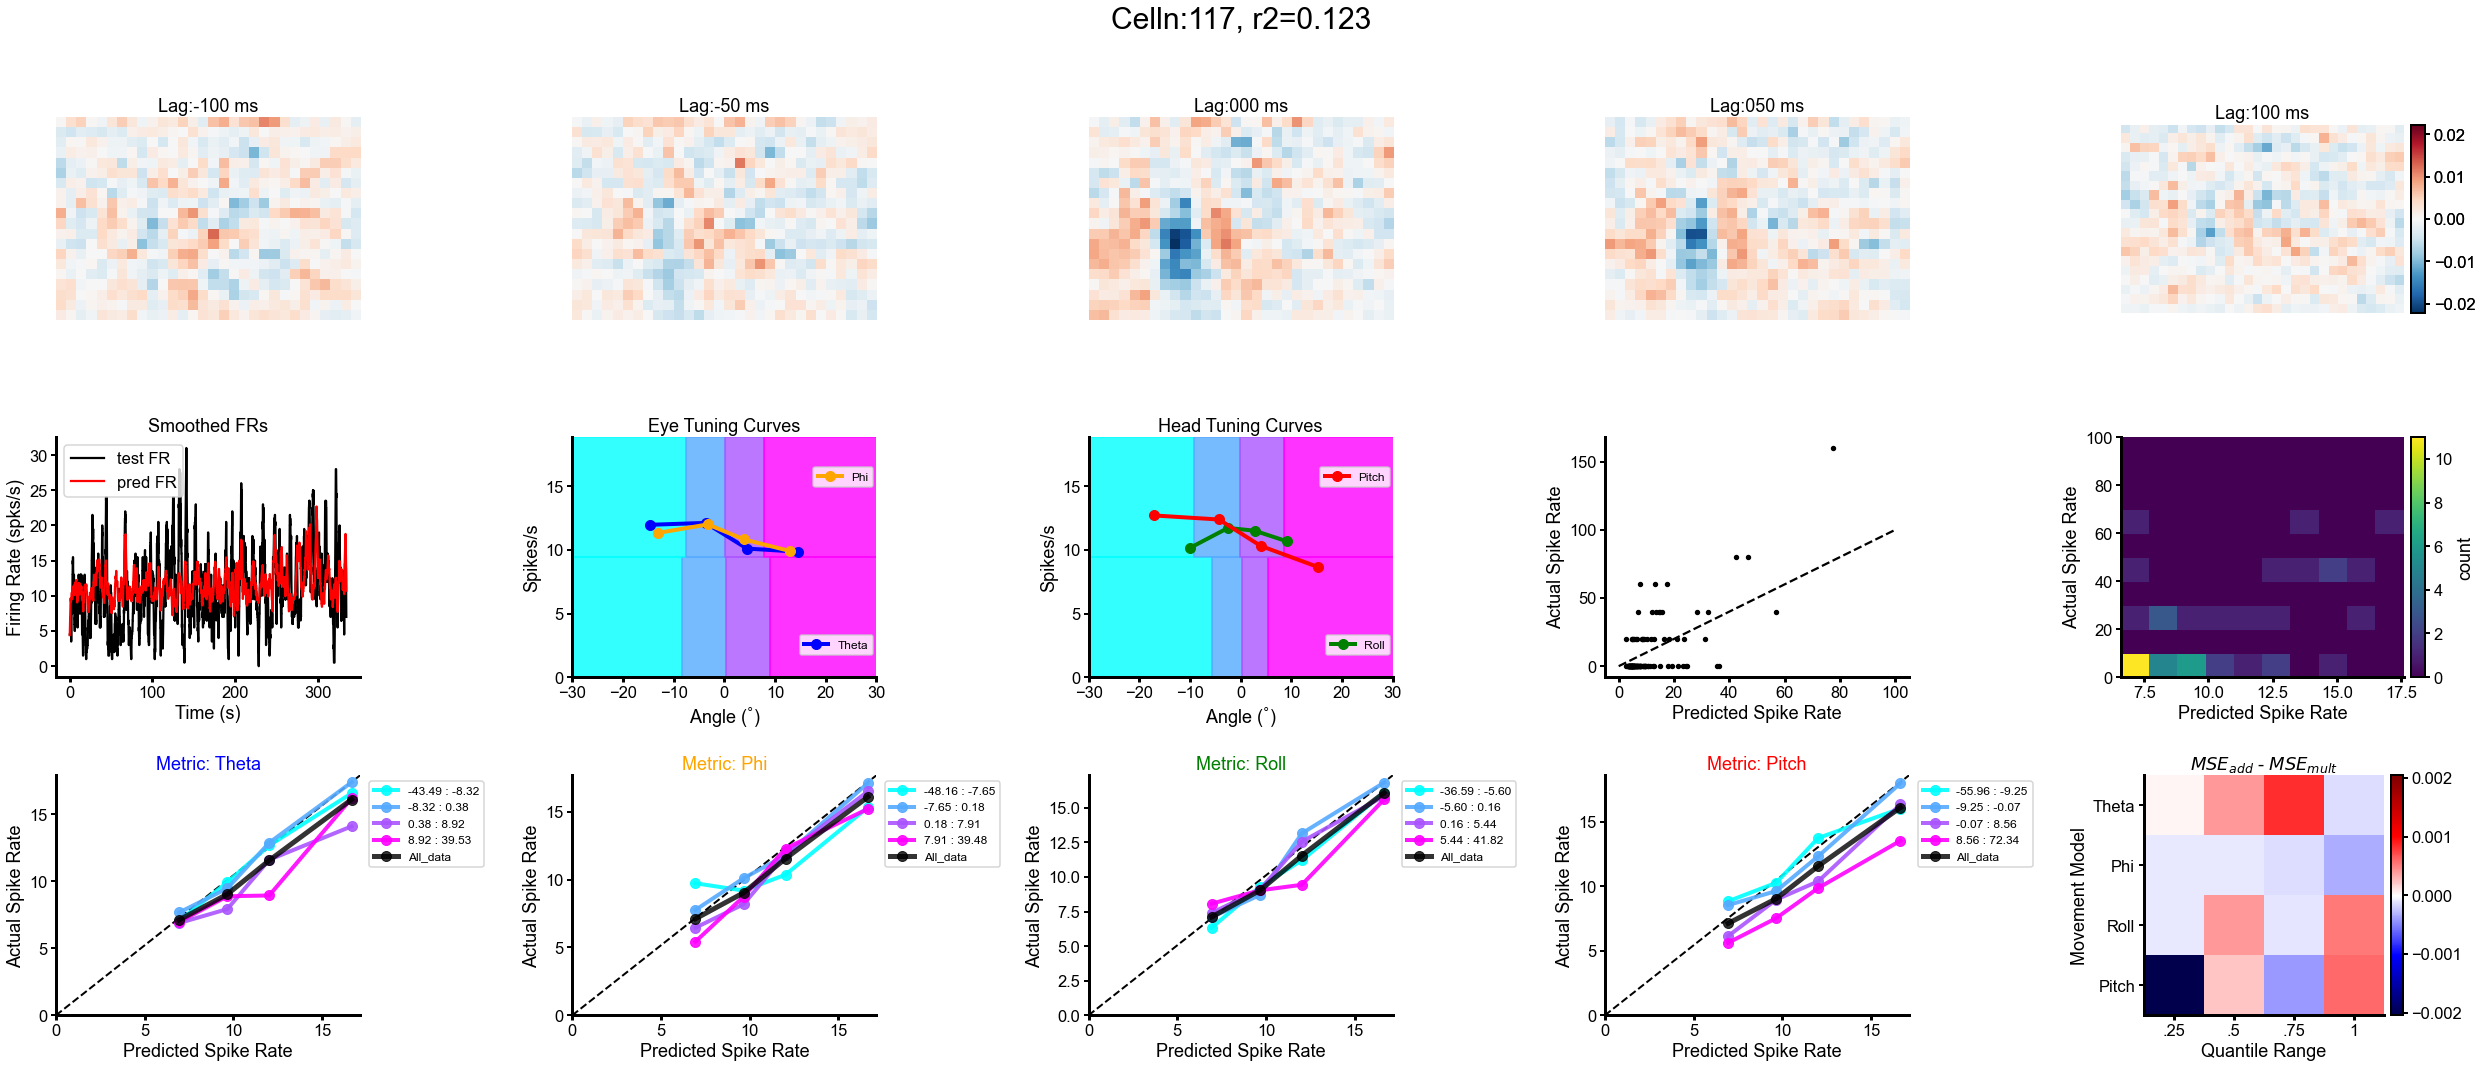

In [19]:
celln= 117 #np.argmax(mr2)
bin_length=40
ncells=model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)

fig, axs = plt.subplots(3,5, figsize=((35,15))) 
gs = axs[0,0].get_gridspec()
gs_sub = gs[0,:].subgridspec(1,nt_glm_lag)
for ax in axs[0,:]:
    ax.remove()
top_grid = np.zeros((nt_glm_lag),dtype=object)
for ind in range(nt_glm_lag):
    top_grid[ind] = fig.add_subplot(gs_sub[0,ind])

predcell = pred_all[:,celln]/model_dt
nspcell = test_nsp[:,celln]/model_dt
test_nsp_smooth=(np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
pred_smooth=(np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
# Set up predicted spike range between 1-99th percentile
stat_bins = 5
pred_range = np.quantile(predcell,[.1,.9])
test_nsp_range = np.quantile(nspcell,[.01,1])
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin) #5


axs[1,0].plot(np.arange(len(test_nsp_smooth))*model_dt,test_nsp_smooth,'k',label='test FR')
axs[1,0].plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', label='pred FR')
axs[1,0].set_xlabel('Time (s)')
axs[1,0].set_ylabel('Firing Rate (spks/s)')
axs[1,0].legend()
axs[1,0].set_title('Smoothed FRs')

crange = np.max(np.abs(sta_all[celln]))
for n in range(nt_glm_lag):
    img = top_grid[n].imshow(sta_all[celln,n],cmap='RdBu_r',vmin=-crange,vmax=crange)
    top_grid[n].axis('off')
    top_grid[n].set_title('Lag:{:03d} ms'.format(int(1000*lag_list[n]*model_dt)))
    top_grid[n].axis('off')
add_colorbar(img)

# Eye Tuning Curve
top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
for i,modeln in enumerate(range(len(titles)-2)):
    metric = move_test[:,modeln]
    nranges = np.quantile(metric,quartiles)
    stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
    norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
    for m in range(len(nranges)-1):
        axs[1,1].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
    #     axs[1,1].errorbar(var_ranges[modeln],tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln],label=titles[modeln],c=clrs[modeln],lw=4,elinewidth=3)
    axs[1,1].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

axs[1,1].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.max(tuning_stds,axis=(1,2))[celln])
axs[1,1].set_xlim(-30,30)
axs[1,1].set_xlabel('Angle ($ ^{\degree}$)')
axs[1,1].set_ylabel('Spikes/s')
axs[1,1].set_title('Eye Tuning Curves')
lines = axs[1,1].get_lines()
legend1 = axs[1,1].legend([lines[0]],[titles[0]],bbox_to_anchor=(1.01, .2), fontsize=12)
legend2 = axs[1,1].legend([lines[1]],[titles[1]],bbox_to_anchor=(1.01, .9), fontsize=12)
axs[1,1].add_artist(legend1)

# Head Tuning Curves
top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
for i, modeln in enumerate(range(2,len(titles))):
    metric = move_test[:,modeln]
#     nranges = np.round(np.quantile(var_ranges[modeln],quartiles),decimals=1)
    nranges = np.round(np.quantile(metric,quartiles),decimals=1)
    stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
    norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
    for m in range(len(nranges)-1):
        axs[1,2].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
#     axs[1,2].errorbar(var_ranges[modeln], tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln], label=titles[modeln], c=clrs[modeln],lw=4,elinewidth=3)
    axs[1,2].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

axs[1,2].set_ylim(bottom=0,top=top_yaxs)
axs[1,2].set_xlim(-30,30)
axs[1,2].set_xlabel('Angle ($ ^{\degree}$)')
axs[1,2].set_ylabel('Spikes/s')
axs[1,2].set_title('Head Tuning Curves')
lines = axs[1,2].get_lines()
legend1 = axs[1,2].legend([lines[0]],[titles[2]],bbox_to_anchor=(1.01, .2), fontsize=12)
legend2 = axs[1,2].legend([lines[1]],[titles[3]],bbox_to_anchor=(1.01, .9), fontsize=12)
axs[1,2].add_artist(legend1)

# axs[1,2].legend(bbox_to_anchor=(1.01, 1), fontsize=12)


# pred_rangelin = np.linspace(pred_range[0],pred_range[1],stat_bins)
axs[1,3].scatter(pred_all[celln]/model_dt,test_nsp[celln]/model_dt,c='k',s=15)
axs[1,3].plot(np.linspace(test_nsp_range[0],test_nsp_range[1]),np.linspace(test_nsp_range[0],test_nsp_range[1]),'k--',zorder=0)
axs[1,3].set_xlabel('Predicted Spike Rate')
axs[1,3].set_ylabel('Actual Spike Rate')
cbar = add_colorbar(img)
# cbar.set_label('count')

hist,xedges,yedges,img =axs[1,4].hist2d(pred_all[celln]/model_dt,test_nsp[celln]/model_dt,range=np.vstack((pred_range,test_nsp_range)))#pred_smooth,test_nsp_smooth)
axs[1,4].set_xlabel('Predicted Spike Rate')
axs[1,4].set_ylabel('Actual Spike Rate')
cbar = add_colorbar(img)
cbar.set_label('count')


mse_add = np.zeros((ncells,len(titles),len(quartiles)-1))
mse_mult = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_add = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_mult = np.zeros((ncells,len(titles),len(quartiles)-1))

traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
traces_mean = np.zeros((ncells,len(titles),stat_bins-1)) # (model_type,quartile,FR)
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
# df_traces = pd.DataFrame([],columns=['modeln','quartile','FR']) 
for modeln in range(len(titles)):
    metric = move_test[:,modeln]
    nranges = np.quantile(metric,quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
    stat_all, edges, _ = binned_statistic(predcell,nspcell, statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    traces_mean[celln,modeln]=stat_all
    max_fr = np.max(stat_all)
#     axs[1,modeln].set_xlim(0,pred_range[1]+np.std(pred_range))
#     axs[1,modeln].set_ylim(0,np.max(stat)+np.std(stat))

    for n in range(len(nranges)-1):
        ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
        pred = predcell[ind]
        sp = nspcell[ind]

        stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
        edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
        traces[celln,modeln,n]=stat_range
        edges_all[celln,modeln,n]=edge_mids
        res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr))
        res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr))
        mse_add[celln, modeln, n] = res_add.fun
        mse_mult[celln, modeln, n] = res_mult.fun
        alpha_add[celln, modeln, n] = res_add.x
        alpha_mult[celln, modeln, n] = res_mult.x

        axs[2,modeln].plot(edge_mids, stat_range,'.-', c=colors[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
        axs[2,modeln].set_title('Metric: {}'.format(titles[modeln]), color=clrs[modeln])
        axs[2,modeln].set_xlabel('Predicted Spike Rate')
        axs[2,modeln].set_ylabel('Actual Spike Rate')
    
    axs[2,modeln].plot([0, 1], [0, 1], 'k--', transform=axs[2,modeln].transAxes, lw=2, zorder=0)
    axs[2,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
    axs[2,modeln].legend(bbox_to_anchor=(1.01, 1), fontsize=12)
#     axs[2,modeln].axis('equal')
    axs[2,modeln].set_xlim(left=0)
#     axs[2,modeln].set(xlim=lims, ylim=lims)
#     axs[2,modeln].set_xlim([0,xbin_pts[-1]])
    axs[2,modeln].set_ylim(bottom=0)

dmodel = mse_add[celln]-mse_mult[celln]
crange = np.max(np.abs(dmodel))
im = axs[2,-1].imshow(dmodel,cmap='seismic',vmin=-crange,vmax=crange)
axs[2,-1].set_yticks(np.arange(0,4))
axs[2,-1].set_yticklabels(titles)
axs[2,-1].set_ylabel('Movement Model')
axs[2,-1].set_xticks(np.arange(0,4))
axs[2,-1].set_xticklabels(['.25','.5','.75','1'])
axs[2,-1].set_xlabel('Quantile Range')
axs[2,-1].set_title('$MSE_{add}$ - $MSE_{mult}$')
cbar = add_colorbar(im)

plt.suptitle('Celln:{}, r2={:.03f}'.format(celln,r2_all[celln]),y=1,fontsize=30)
plt.tight_layout()


# fig.savefig(FigPath/'CellSummary_N{}_T{:02d}.png'.format(celln,nt_glm_lag), facecolor='white', transparent=True)

  0%|          | 0/4 [00:00<?, ?it/s]

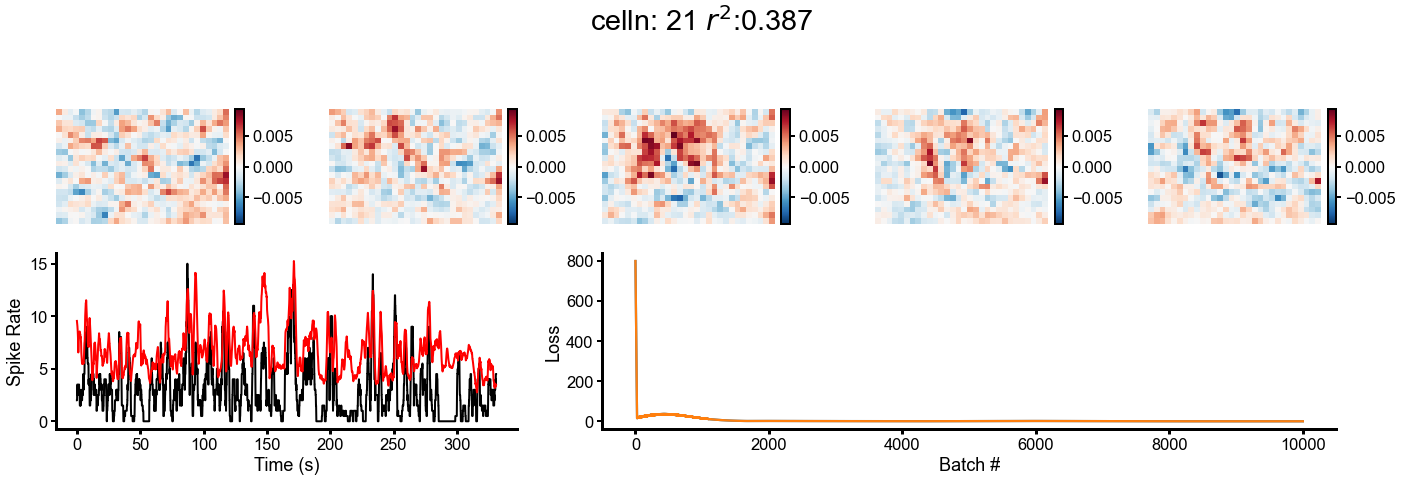

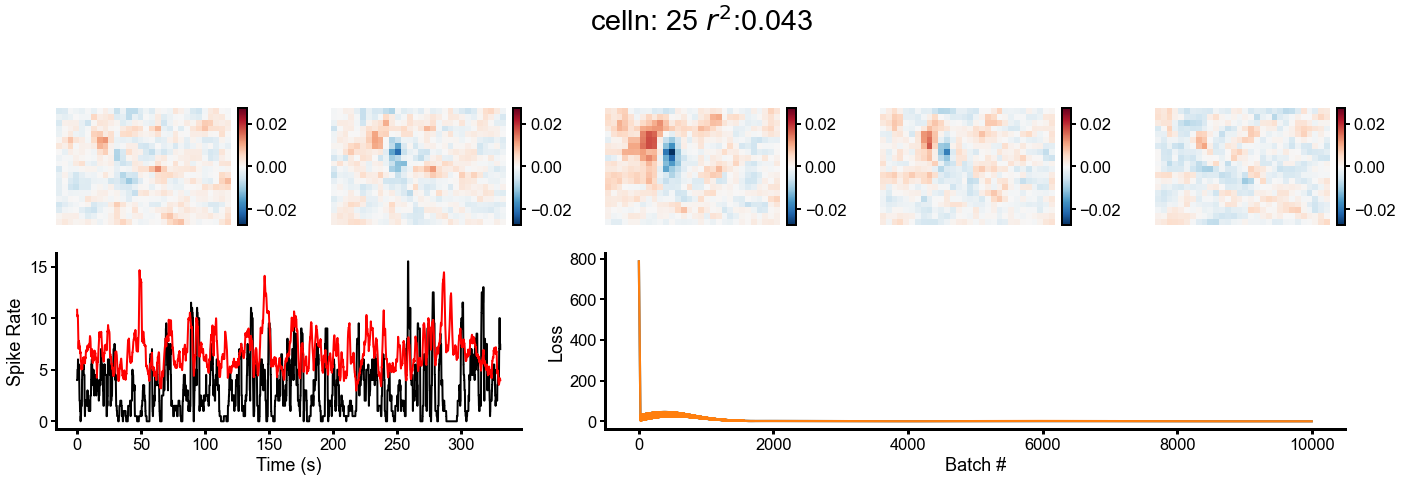

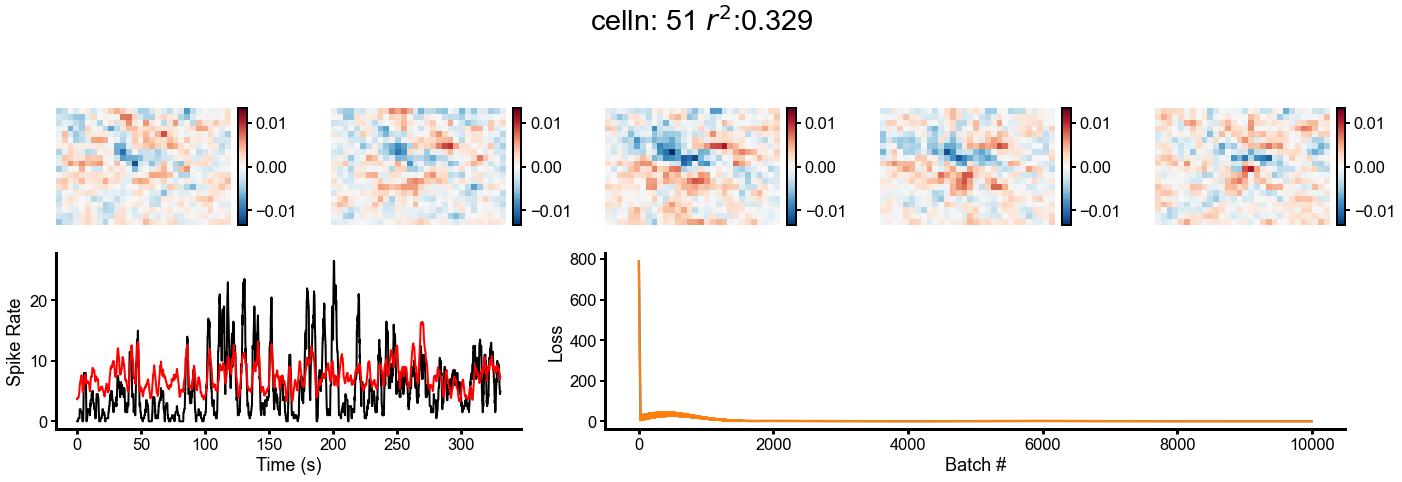

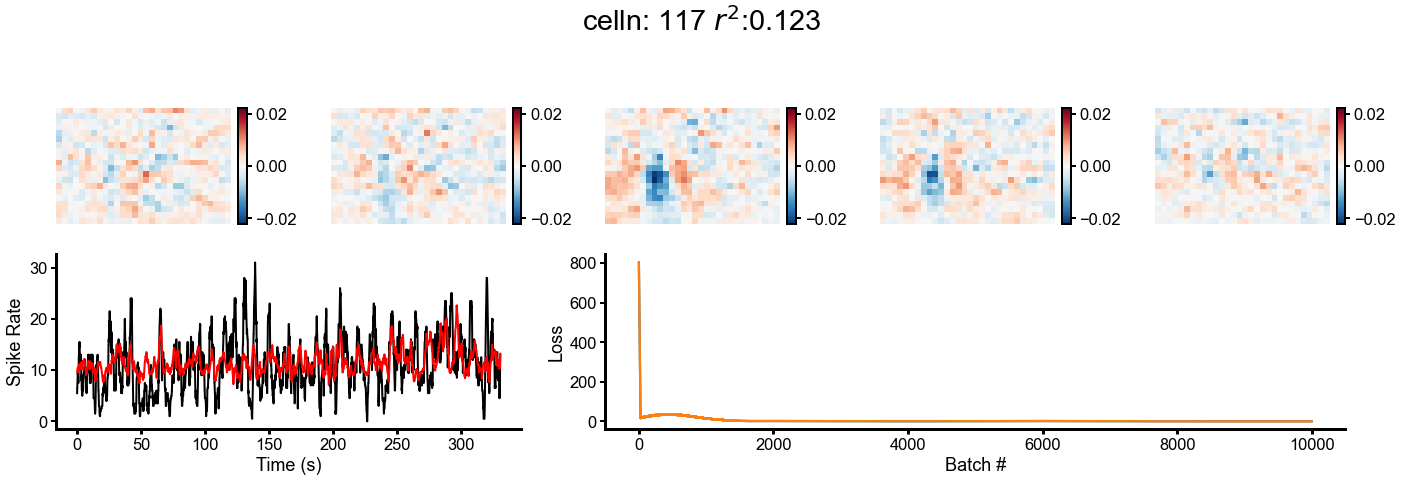

In [350]:
bin_length=40

for n, celln in enumerate(tqdm([21,25,51,117])):
    fig2 = plt.figure(constrained_layout=False, figsize=(20,7))
    spec2 = gridspec.GridSpec(ncols=nt_glm_lag, nrows=2, figure=fig2)
    axs = np.array([fig2.add_subplot(spec2[0, n]) for n in range(nt_glm_lag)])
    f2_ax6 = fig2.add_subplot(spec2[1, :nt_glm_lag//2])
    f2_ax7 = fig2.add_subplot(spec2[1, nt_glm_lag//2:])
    crange = np.max(np.abs(sta_all[celln]))
    for n,ax in enumerate(axs):
        im = ax.imshow(sta_all[celln,n],'RdBu_r',vmin=-crange,vmax=crange)
        cbar = add_colorbar(im)
        ax.axis('off')

    sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    f2_ax6.plot(np.arange(len(sp_smooth))*model_dt,sp_smooth, 'k', lw=2)
    pred_smooth = ((np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    f2_ax6.plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', lw=2)
    f2_ax6.set_xlabel('Time (s)')
    f2_ax6.set_ylabel('Spike Rate')
    f2_ax7.plot(tloss_trace[:,celln])
    f2_ax7.plot(vloss_trace[:,celln])
    f2_ax7.set_xlabel('Batch #')
    f2_ax7.set_ylabel('Loss')
    r2 = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2
    plt.suptitle('celln: {} $r^2$:{:.03f}'.format(celln, r2))
    plt.tight_layout()

## Shuffle Comparison

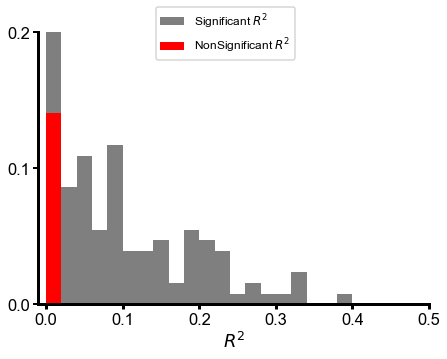

In [337]:
model_dt=.05
# for model_dt in [.025,.05,.1]:
GLM_Vis_shuff = ioh5.load(save_dir/'GLM_{}_Data_VisOnly_dt{:03d}_T{:02d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisOnly_dt{:03d}_T{:02d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
locals().update(GLM_Vis)
max_shuff = np.max(GLM_Vis_shuff['r2_all']**2)
r2_all = (GLM_Vis['r2_all'])
fig,ax = plt.subplots(1,1,figsize=(7,5))

sig = r2_all[r2_all>max_shuff]
non_sig = r2_all[r2_all<max_shuff]
hbins=.02
count,edges = np.histogram(r2_all,bins=np.arange(0,1,hbins))
count_shuff,edges_shuff = np.histogram(non_sig,bins=np.arange(0,1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
edges_mid_shuff = np.array([(edges_shuff[i]+edges_shuff[i+1])/2 for i in range(len(edges_shuff)-1)])
ax.bar(edges_mid, count/len(GLM_Vis['r2_all']),color='k',width=hbins,alpha=.5, label='Significant $R^2$')
ax.bar(edges_mid_shuff, count_shuff/len(GLM_Vis['r2_all']),color='r',width=hbins,alpha=1, label='NonSignificant $R^2$')
ax.set_xlabel('$R^2$')
ax.set_yticks(np.arange(0,1,.1))
ax.set_yticklabels(np.round(np.arange(0,1,.1),decimals=3))
ax.set_xlim(-.01,.5)
ax.set_ylim(0,.2)
ax.legend(fontsize=12,loc=(.3,.9))

# Plotting All Cells

In [ ]:
##### Single Time Point STA #####
bin_length=40
r2_all = np.zeros(output_size)
for n, celln in enumerate(tqdm([21,25,51,117])):
    crange = np.max(np.abs(sta[celln]))
    print(crange)
    fig,ax = plt.subplots(1,3,figsize=(20,5))
    im=ax[0].imshow(sta[celln],'RdBu_r',vmin=-crange,vmax=crange)
    cbar = add_colorbar(im)
    sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    ax[1].plot(sp_smooth, 'k', lw=2)
    pred_smooth = ((np.convolve(pred[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    ax[1].plot(pred_smooth,'r', lw=2)
    ax[2].plot(tloss_trace[:,celln])
    ax[2].plot(vloss_trace[:,celln])
    ax[2].set_ylim(bottom=0)
    r2_all[celln] = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2
    plt.suptitle('celln: {} \n $\lambda$:{:.02f}, $r^2$:{:.03f}'.format(celln, lambdas[n],r2_all[celln]))
    plt.tight_layout()
#         pdf.savefig()
#         plt.close()

In [268]:
##### Multi-lag STA #####
bin_length=40
if do_shuffle:
    pdf_name = FigPath/ 'Vis_GLM_{}_dt{:03d}_T{:02d}_shuff.pdf'.format(model_type,int(model_dt*1000),nt_glm_lag)
else:
    pdf_name = FigPath/ 'Vis_GLM_{}_dt{:03d}_T{:02d}.pdf'.format(model_type,int(model_dt*1000),nt_glm_lag)
with PdfPages(pdf_name) as pdf:
    r2_all = np.zeros(output_size)
    for n, celln in enumerate(tqdm(range(output_size))):
        fig2 = plt.figure(constrained_layout=False, figsize=(20,7))
        spec2 = gridspec.GridSpec(ncols=nt_glm_lag, nrows=2, figure=fig2)
        axs = np.array([fig2.add_subplot(spec2[0, n]) for n in range(nt_glm_lag)])
        f2_ax6 = fig2.add_subplot(spec2[1, :nt_glm_lag//2])
        f2_ax7 = fig2.add_subplot(spec2[1, nt_glm_lag//2:])
        crange = np.max(np.abs(sta[celln]))
        for n,ax in enumerate(axs):
            im = ax.imshow(sta[celln,n],'RdBu_r',vmin=-crange,vmax=crange)
            cbar = add_colorbar(im)
            ax.axis('off')

        sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
        f2_ax6.plot(sp_smooth, 'k', lw=2)
        pred_smooth = ((np.convolve(pred[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
        f2_ax6.plot(pred_smooth,'r', lw=2)
        f2_ax7.plot(tloss_trace[:,celln])
        f2_ax7.plot(vloss_trace[:,celln])
        r2_all[celln] = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2
        plt.suptitle('celln: {} $r^2$:{:.03f}'.format(celln, r2_all[celln]))
        plt.tight_layout()
        pdf.savefig()
        plt.close()

  0%|          | 0/128 [00:00<?, ?it/s]

# VisMov Poisson GLM

In [9]:
lag_list = np.array([-2,-1,0,1,2]) #np.array([-1,0,1,2,3]) #,np.arange(minlag,maxlag,np.floor((maxlag-minlag)/nt_glm_lag).astype(int))
nt_glm_lag = len(lag_list)
print(lag_list,1000*lag_list*model_dt)
do_shuffle = False
model_type = 'Pytorch'


# for do_shuffle in [False,True]:
# Load Data
data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=True,free_move=free_move, has_imu=free_move, has_mouse=False)
locals().update(data)

# Initialize movement combinations
titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
titles_all = []
for n in range(1,len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))

# train_dgaze_p = train_dth + np.diff(train_gz,append=0)
# train_dgaze_n = train_dth - np.diff(train_gz,append=0)
# test_dgaze_p = test_dth + np.diff(test_gz,append=0)
# test_dgaze_n = test_dth - np.diff(test_gz,append=0)
move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],train_pitch[:,np.newaxis]))
move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis])) 
model_move = np.hstack((model_th[:,np.newaxis],model_phi[:,np.newaxis],model_roll[:,np.newaxis],model_pitch[:,np.newaxis]))
model_move = model_move - np.mean(model_move,axis=0)
move_test = move_test - np.mean(move_test,axis=0)

##### Start GLM Parallel Processing #####
nks = np.shape(train_vid)[1:]; nk = nks[0]*nks[1]*nt_glm_lag
n=4; ind=0
perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
##### Start GLM Parallel Processing #####
# Reshape data (video) into (T*n)xN array
rolled_vid = np.hstack([np.roll(model_vid_sm, nframes, axis=0) for nframes in lag_list]) # nt_glm_lag
x_train = rolled_vid[train_idx].reshape(len(train_idx),-1)
x_test = rolled_vid[test_idx].reshape(len(test_idx),-1)

MovModel = 1
# Reshape data (video) into (T*n)xN array
rolled_vid = np.hstack([np.roll(model_vid_sm, nframes, axis=0) for nframes in lag_list]) # nt_glm_lag
if MovModel == 0:
    mx_train = move_train[:,perms[ind]]
    mx_test = move_test[:,perms[ind]]
    xtr = torch.from_numpy(mx_train.astype(np.float32)).to(device)
    xte = torch.from_numpy(mx_test.astype(np.float32)).to(device)    
    move_features = mx_train.shape[-1]
    nk = 0
elif MovModel == 1:
    xtr = torch.from_numpy((rolled_vid[train_idx].reshape(len(train_idx),-1)).astype(np.float32)).to(device)
    xte = torch.from_numpy((rolled_vid[test_idx].reshape(len(test_idx),-1)).astype(np.float32)).to(device)
    move_features = None
elif MovModel == 2:
    x_train_m2 = np.concatenate((x_train,move_train[:,perms[ind]]),axis=1)
    x_test_m2 = np.concatenate((x_test,move_test[:,perms[ind]]),axis=1)
    xtr = torch.from_numpy(x_train_m2.astype(np.float32)).to(device)
    xte = torch.from_numpy(x_test_m2.astype(np.float32)).to(device)
    move_features = x_train_m2.shape[-1]-nk
elif MovModel == 3:
    x_train_m3 = np.hstack((x_train,np.hstack([x_train*move_train[:,modeln][:,np.newaxis] for modeln in np.arange(len(titles))]), move_train[:,perms[ind]]))
    x_test_m3 = np.hstack((x_test,np.hstack([x_test*move_test[:,modeln][:,np.newaxis] for modeln in np.arange(len(titles))]), move_test[:,perms[ind]]))
    xtr = torch.from_numpy(x_train_m3.astype(np.float32)).to(device)
    xte = torch.from_numpy(x_test_m3.astype(np.float32)).to(device)    
    move_features = x_train_m3.shape[-1]-nk

    
ytr = torch.from_numpy(train_nsp.astype(np.float32)).to(device)
yte = torch.from_numpy(test_nsp.astype(np.float32)).to(device)
print('move_features: {}'.format(move_features))

[-2 -1  0  1  2] [-100.  -50.    0.   50.  100.]
Done Loading Aligned Data
TRAIN: 11505 TEST: 4931
move_features: None


In [10]:
class PoissonGLM_VM(nn.Module):
    def __init__(self, in_features, out_features, bias=True, reg_lam=None, reg_alph=None, move_features=None):
        super(PoissonGLM_VM, self).__init__()
        self.move_features = move_features
        if self.move_features != None:
            self.lam_m = torch.nn.Parameter(torch.Tensor(out_features))
            self.alpha_m = torch.nn.Parameter(torch.Tensor(out_features))
        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias
        self.weight = torch.nn.Parameter(torch.Tensor(out_features, in_features),)
        self.reg_lam = reg_lam
        self.reg_alph = reg_alph
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        if self.reg_lam != None:
            self.lam = torch.nn.Parameter(torch.Tensor(out_features))
        if self.reg_alph != None:
            self.alpha = torch.nn.Parameter(torch.Tensor(out_features))
            
        self.lossfn = torch.nn.PoissonNLLLoss(log_input=True,reduction='mean')
        self.reset_parameters()
        
    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.weight) #, a=np.sqrt(5)
        if self.reg_lam != None:
            torch.nn.init.constant_(self.lam,self.reg_lam)
        if self.reg_alph != None:
            torch.nn.init.constant_(self.alpha,self.reg_alph)
        if self.move_features != None:
            torch.nn.init.constant_(self.lam_m,1)#self.reg_lam)
            torch.nn.init.constant_(self.alpha_m,1)#self.reg_alph)
        if self.bias is not None:
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / np.sqrt(fan_in)
            torch.nn.init.uniform_(self.bias, -bound, bound)
        
    def forward(self, inputs):
        x, y = inputs.shape
        if y != self.in_features:
            print(f'Wrong Input Features. Please use tensor with {self.in_features} Input Features')
            return 0
        output = inputs.matmul(self.weight.t())
        if self.bias is not None:
            output = output + self.bias
        ret = torch.log1p(torch.exp(output))
        return ret
    
    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )
    
    def loss(self,Yhat, Y): 
        # self.lossfn(Yhat,Y) 
        if self.reg_lam != None:
            if self.move_features != None:
                loss_vec = torch.mean(Yhat-Y*torch.log(Yhat)) + torch.clamp(self.lam,min=0)*(torch.linalg.norm(self.weight[:,:-self.move_features],axis=1,ord=2)) + torch.clamp(self.alpha,0,1)*torch.linalg.norm(self.weight[:,:-self.move_features],axis=1,ord=1) +\
                            torch.clamp(self.lam_m,min=0)*(torch.linalg.norm(self.weight[:,-self.move_features:],axis=1,ord=2)) + torch.clamp(self.alpha_m,0,1)*torch.linalg.norm(self.weight[:,-self.move_features:],axis=1,ord=1) 
            else:
                loss_vec = torch.mean(Yhat-Y*torch.log(Yhat)) + torch.clamp(self.lam,min=0)*(torch.linalg.norm(self.weight,axis=1,ord=2)) + torch.clamp(self.alpha,0,1)*torch.linalg.norm(self.weight,axis=1,ord=1) 
        else: 
            loss_vec = torch.mean(Yhat-Y*torch.log(Yhat))
            
#         if self.move_features != None:
#             loss_vec = torch.mean(Yhat-Y*torch.log(Yhat)) + torch.clamp(self.lam,min=0)*(torch.linalg.norm(self.weight,axis=1)) + torch.clamp(self.alpha,0,1)*torch.sum(torch.abs(self.weight),axis=1) 
        return loss_vec


In [11]:
input_size = xtr.shape[1]
output_size = ytr.shape[1]
reg_lam = 512
reg_alph = 10
l1 = PoissonGLM_VM(input_size,output_size,reg_lam=reg_lam,reg_alph=reg_alph,move_features=move_features).to(device)
if MovModel == 1:
    optimizer = optim.ASGD([{'params': [l1.weight, l1.bias]}, 
                           {'params': [l1.lam, l1.alpha,] , 'lr': .01},
                           ], lr=1e-3) 
else:
    optimizer = optim.ASGD([{'params': [l1.weight, l1.bias]}, 
                       {'params': [l1.lam, l1.alpha,l1.lam_m, l1.alpha_m] , 'lr': .01},
                       ], lr=1e-3) 
# optimizer = optim.ASGD(params=l1.parameters()) #
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1000)

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=[1e-4, .1], max_lr=[1e-3, 16], cycle_momentum=False)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=[0.001,], max_lr=[10], cycle_momentum=False)

lossfn = torch.nn.PoissonNLLLoss(log_input=True,reduction='mean')

Nbatches= 10000
if move_features != None:
    reg_params = np.zeros((Nbatches,output_size,4))
    reg_titles = ['lambda','lambda_m','alpha','alpha_m']
else:
    reg_params = np.zeros((Nbatches,output_size,2))
    reg_titles = ['lambda','alpha']
vloss_trace = np.zeros((Nbatches,output_size))      
tloss_trace = np.zeros((Nbatches,output_size))      
early_stopping = EarlyStopping(patience=500,min_delta=.5)
# lam_grad = np.zeros((Nbatches,output_size))
for batchn in tqdm(np.arange(Nbatches)):
    out = l1(xtr)
    loss = l1.loss(out,ytr)
    pred = l1(xte)
    val_loss = l1.loss(pred,yte)
    vloss_trace[batchn] = val_loss.clone().cpu().detach().numpy()
    tloss_trace[batchn] = loss.clone().cpu().detach().numpy()
    if move_features != None:
        reg_params[batchn] = torch.stack((l1.lam.data.clone().cpu(),l1.lam_m.data.clone().cpu(),l1.alpha.data.clone().cpu(),l1.alpha_m.data.clone().cpu())).numpy().T
    else:
        reg_params[batchn] = torch.stack((l1.lam.data.clone().cpu(),l1.alpha.data.clone().cpu())).numpy().T
    optimizer.zero_grad()
    loss.backward(torch.ones_like(loss))
    optimizer.step()
    scheduler.step()
#     lam_grad[batchn]= l1.lam.grad.detach().cpu().numpy()
#     early_stopping(val_loss.item())
#     if early_stopping.early_stop:
#         break
pred_all = l1(xte).cpu().detach().numpy()
if MovModel != 0:
    sta_all = l1.weight.cpu().detach().numpy()[:,:(nk)].reshape((output_size,nt_glm_lag)+nks)
if MovModel != 1:
    w_move = l1.weight.cpu().detach().numpy()[:,(nk):]

  0%|          | 0/10000 [00:00<?, ?it/s]

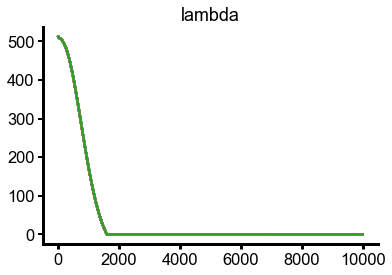

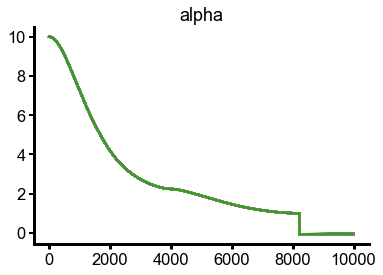

In [12]:
# reg_titles = ['lambda','lambda_m','alpha','alpha_m']
# reg_titles = ['lambda','alpha']
for n in range(reg_params.shape[-1]):
    fig,ax = plt.subplots()
    ax.plot(reg_params[:,:,n])
    ax.set_title(reg_titles[n])

In [13]:
bin_length=40
r2_all = np.zeros(output_size)
for celln in range(output_size):
    sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    pred_smooth = ((np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    r2_all[celln] = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2

if MovModel == 0:
    GLM_Data = {'r2_all': r2_all,
                'spks_all': test_nsp,
                'pred_all': pred_all,
                'w_move': w_move}
elif MovModel == 1:
    GLM_Data = {'r2_all': r2_all,
                'sta_all': sta_all,
                'spks_all': test_nsp,
                'pred_all': pred_all,
               }
else:
    GLM_Data = {'r2_all': r2_all,
                'sta_all': sta_all,
                'spks_all': test_nsp,
                'pred_all': pred_all,
                'w_move': w_move}

if do_shuffle:
    save_datafile = save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel)
else:
    save_datafile = save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel)
ioh5.save(save_datafile, GLM_Data)
print(save_datafile)

/home/seuss/Research/SensoryMotorPred_Data/data/062921/G6HCK1ALTRN/fm1/GLM_Pytorch_Data_VisMov_dt050_T05_MovModel1.h5




## Plotting

In [14]:
bin_length=40
data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=False,free_move=free_move, has_imu=free_move, has_mouse=False)
locals().update(data)
# if do_shuffle:
#     GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel))
# else:
#     GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel))
# locals().update(GLM_Vis)
##### Explore Neurons #####
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
# Initialize movement combinations
titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
titles_all = []
for n in range(1,len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))

# train_dgaze_p = train_dth + np.diff(train_gz,append=0)
# train_dgaze_n = train_dth - np.diff(train_gz,append=0)
# test_dgaze_p = test_dth + np.diff(test_gz,append=0)
# test_dgaze_n = test_dth - np.diff(test_gz,append=0)
move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],train_pitch[:,np.newaxis]))#, train_dth[:,np.newaxis],train_dphi[:,np.newaxis]))
move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
# move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))# test_dth[:,np.newaxis],test_dphi[:,np.newaxis]))
model_move = np.hstack((model_th[:,np.newaxis],model_phi[:,np.newaxis],model_roll[:,np.newaxis],model_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
model_move = model_move - np.mean(model_move,axis=0)
move_test = move_test - np.mean(move_test,axis=0)
# Create all tuning curves for plotting
N_bins=10
ncells = model_nsp.shape[-1]
ax_ylims = np.zeros((model_nsp.shape[-1],len(titles)))
tuning_curves = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
tuning_stds = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
var_ranges = np.zeros((len(titles),N_bins-1))
for modeln in range(len(titles)):
    metric = move_test[:,modeln]
    tuning, tuning_std, var_range = tuning_curve(test_nsp, metric, N_bins=N_bins, model_dt=model_dt, Nstds=2)
    tuning_curves[:,modeln] = tuning
    tuning_stds[:,modeln] = tuning_std
    ax_ylims[:,modeln] = np.nanmax(tuning,axis=1)
    var_ranges[modeln] = var_range

Done Loading Aligned Data
TRAIN: 11505 TEST: 4931


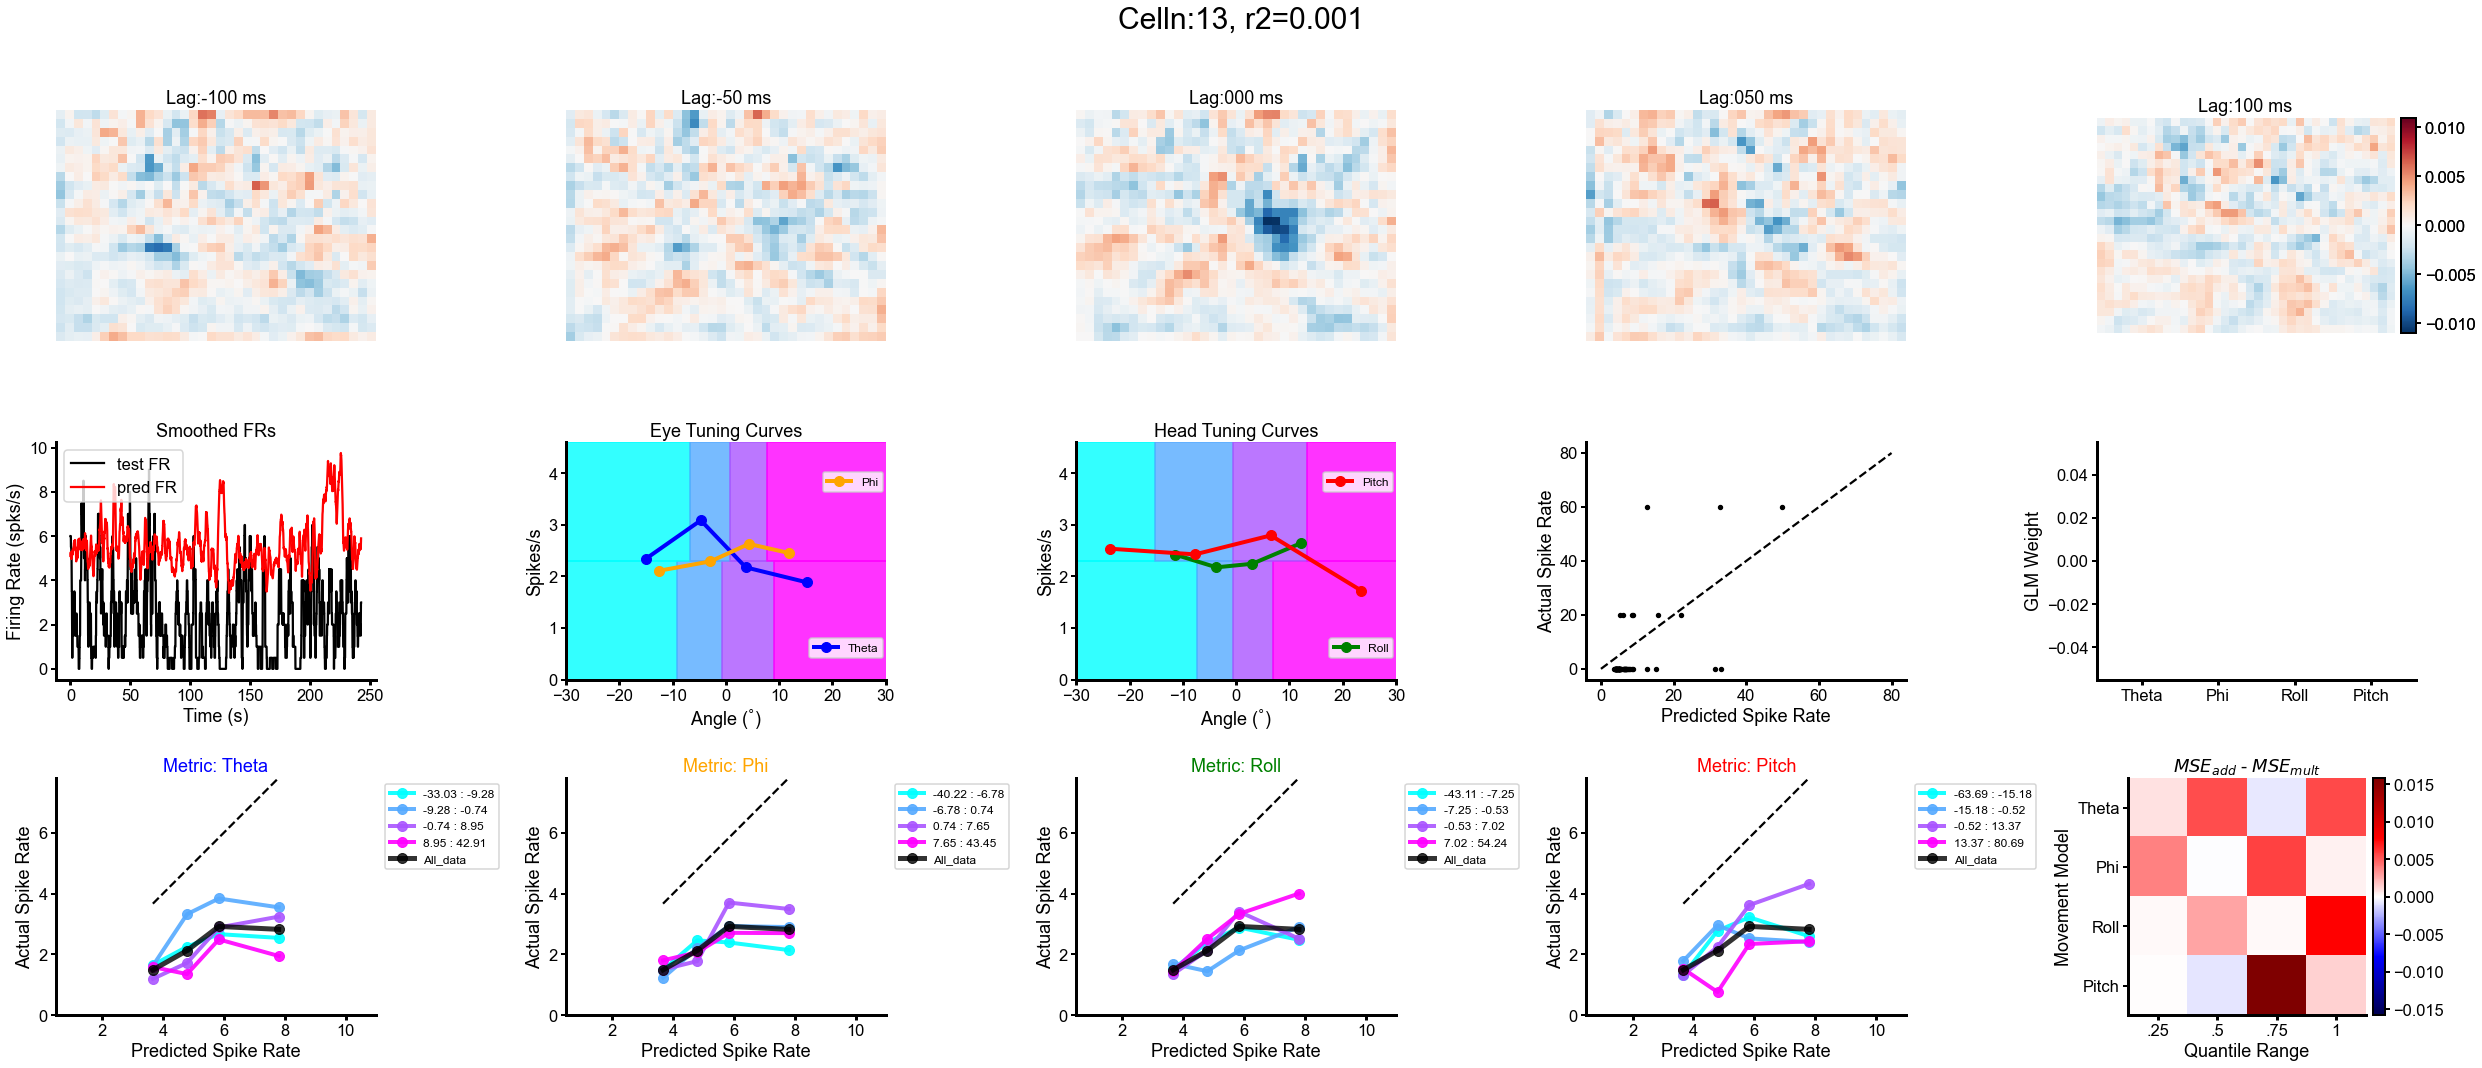

In [37]:
celln =13# np.argmax(r2_all)
bin_length = 40
ncells=model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)

fig, axs = plt.subplots(3,5, figsize=((35,15))) 
gs = axs[0,0].get_gridspec()
gs_sub = gs[0,:].subgridspec(1,nt_glm_lag)
for ax in axs[0,:]:
    ax.remove()
top_grid = np.zeros((nt_glm_lag),dtype=object)
for ind in range(nt_glm_lag):
    top_grid[ind] = fig.add_subplot(gs_sub[0,ind])

predcell = pred_all[:,celln]/model_dt
nspcell = test_nsp[:,celln]/model_dt
test_nsp_smooth=((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
pred_smooth=((np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
# Set up predicted spike range between 1-99th percentile
stat_bins = 5
pred_range = np.quantile(predcell,[.1,.9])
test_nsp_range = np.quantile(nspcell,[.01,1])
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin) #5


axs[1,0].plot(np.arange(len(test_nsp_smooth))*model_dt,test_nsp_smooth,'k',label='test FR')
axs[1,0].plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', label='pred FR')
axs[1,0].set_xlabel('Time (s)')
axs[1,0].set_ylabel('Firing Rate (spks/s)')
axs[1,0].legend()
axs[1,0].set_title('Smoothed FRs')

crange = np.max(np.abs(sta_all[celln]))
for n in range(nt_glm_lag):
    img = top_grid[n].imshow(sta_all[celln,n],cmap='RdBu_r',vmin=-crange,vmax=crange)
    top_grid[n].axis('off')
    top_grid[n].set_title('Lag:{:03d} ms'.format(int(1000*lag_list[n]*model_dt)))
    top_grid[n].axis('off')
add_colorbar(img)

# Eye Tuning Curve
top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
for i,modeln in enumerate(range(len(titles)-2)):
    metric = move_test[:,modeln]
    nranges = np.quantile(metric,quartiles)
    stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
    norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
    for m in range(len(nranges)-1):
        axs[1,1].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
    #     axs[1,1].errorbar(var_ranges[modeln],tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln],label=titles[modeln],c=clrs[modeln],lw=4,elinewidth=3)
    axs[1,1].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

axs[1,1].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
axs[1,1].set_xlim(-30,30)
axs[1,1].set_xlabel('Angle ($ ^{\degree}$)')
axs[1,1].set_ylabel('Spikes/s')
axs[1,1].set_title('Eye Tuning Curves')
lines = axs[1,1].get_lines()
legend1 = axs[1,1].legend([lines[0]],[titles[0]],bbox_to_anchor=(1.01, .2), fontsize=12)
legend2 = axs[1,1].legend([lines[1]],[titles[1]],bbox_to_anchor=(1.01, .9), fontsize=12)
axs[1,1].add_artist(legend1)

# Head Tuning Curves
top_yaxs = np.max(ax_ylims[celln])+2*np.nanmax(tuning_stds[celln])
for i, modeln in enumerate(range(2,len(titles))):
    metric = move_test[:,modeln]
#     nranges = np.round(np.quantile(var_ranges[modeln],quartiles),decimals=1)
    nranges = np.round(np.quantile(metric,quartiles),decimals=1)
    stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
    norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
    for m in range(len(nranges)-1):
        axs[1,2].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
#     axs[1,2].errorbar(var_ranges[modeln], tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln], label=titles[modeln], c=clrs[modeln],lw=4,elinewidth=3)
    axs[1,2].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

axs[1,2].set_ylim(bottom=0,top=top_yaxs)
axs[1,2].set_xlim(-30,30)
axs[1,2].set_xlabel('Angle ($ ^{\degree}$)')
axs[1,2].set_ylabel('Spikes/s')
axs[1,2].set_title('Head Tuning Curves')
lines = axs[1,2].get_lines()
legend1 = axs[1,2].legend([lines[0]],[titles[2]],bbox_to_anchor=(1.01, .2), fontsize=12)
legend2 = axs[1,2].legend([lines[1]],[titles[3]],bbox_to_anchor=(1.01, .9), fontsize=12)
axs[1,2].add_artist(legend1)

# axs[1,2].legend(bbox_to_anchor=(1.01, 1), fontsize=12)


# pred_rangelin = np.linspace(pred_range[0],pred_range[1],stat_bins)
axs[1,3].scatter(pred_all[celln]/model_dt,test_nsp[celln]/model_dt,c='k',s=15)
axs[1,3].plot(np.linspace(test_nsp_range[0],test_nsp_range[1]),np.linspace(test_nsp_range[0],test_nsp_range[1]),'k--',zorder=0)
axs[1,3].set_xlabel('Predicted Spike Rate')
axs[1,3].set_ylabel('Actual Spike Rate')
cbar = add_colorbar(img)
# cbar.set_label('count')

if MovModel == 1:
    w_move = np.zeros((model_nsp.shape[-1],len(titles)))
elif MovModel == 3:
    Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],nt_glm_lag,len(titles))+nks)
    w_move = w_move[:,-len(titles):]
for modeln in range(len(titles)):
    axs[1,4].bar(modeln, w_move[celln,modeln], color=clrs[modeln])
    axs[1,4].set_xticks(np.arange(0,len(titles)))
    axs[1,4].set_xticklabels(titles)
    axs[1,4].set_ylabel('GLM Weight')


mse_add = np.zeros((ncells,len(titles),len(quartiles)-1))
mse_mult = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_add = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_mult = np.zeros((ncells,len(titles),len(quartiles)-1))

traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
traces_mean = np.zeros((ncells,len(titles),stat_bins-1)) # (model_type,quartile,FR)
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
# df_traces = pd.DataFrame([],columns=['modeln','quartile','FR']) 
for modeln in range(len(titles)):
    metric = move_test[:,modeln]
    nranges = np.quantile(metric,quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
    stat_all, edges, _ = binned_statistic(predcell,nspcell, statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    traces_mean[celln,modeln]=stat_all
    max_fr = np.max(stat_all)
#     axs[1,modeln].set_xlim(0,pred_range[1]+np.std(pred_range))
#     axs[1,modeln].set_ylim(0,np.max(stat)+np.std(stat))

    for n in range(len(nranges)-1):
        ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
        pred = predcell[ind]
        sp = nspcell[ind]

        stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
        edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
        traces[celln,modeln,n]=stat_range
        edges_all[celln,modeln,n]=edge_mids
        res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr))
        res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr))
        mse_add[celln, modeln, n] = res_add.fun
        mse_mult[celln, modeln, n] = res_mult.fun
        alpha_add[celln, modeln, n] = res_add.x
        alpha_mult[celln, modeln, n] = res_mult.x

        axs[2,modeln].plot(edge_mids, stat_range,'.-', c=colors[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
        axs[2,modeln].set_title('Metric: {}'.format(titles[modeln]), color=clrs[modeln])
        axs[2,modeln].set_xlabel('Predicted Spike Rate')
        axs[2,modeln].set_ylabel('Actual Spike Rate')
    
    lim_max = np.max(edge_mids)#+1.5*np.std(edges)
    lim_min = np.min(edge_mids)#-1.5*np.std(edges)
    lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
    axs[2,modeln].plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
    axs[2,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
    axs[2,modeln].legend(bbox_to_anchor=(1.01, 1), fontsize=12)
    axs[2,modeln].axis('equal')
#     axs[2,modeln].set_xlim(left=0)
    axs[2,modeln].set(xlim=lims, ylim=lims)
#     axs[2,modeln].set_xlim([0,xbin_pts[-1]])
    axs[2,modeln].set_ylim(bottom=0)

dmodel = mse_add[celln]-mse_mult[celln]
crange = np.max(np.abs(dmodel))
im = axs[2,-1].imshow(dmodel,cmap='seismic',vmin=-crange,vmax=crange)
axs[2,-1].set_yticks(np.arange(0,4))
axs[2,-1].set_yticklabels(titles)
axs[2,-1].set_ylabel('Movement Model')
axs[2,-1].set_xticks(np.arange(0,4))
axs[2,-1].set_xticklabels(['.25','.5','.75','1'])
axs[2,-1].set_xlabel('Quantile Range')
axs[2,-1].set_title('$MSE_{add}$ - $MSE_{mult}$')
cbar = add_colorbar(im)

plt.suptitle('Celln:{}, r2={:.03f}'.format(celln,r2_all[celln]),y=1,fontsize=30)
plt.tight_layout()


# fig.savefig(FigPath/'CellSummary_N{}_T{:02d}.png'.format(celln,nt_glm_lag), facecolor='white', transparent=True)

In [33]:
lim_max = np.max(edges)#+1.5*np.std(edges)
lim_min = np.min(edges)#-1.5*np.std(edges)
lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
lims

(1.2856909036636353, 11.534314823150632)

(0, 12.400492357429034)

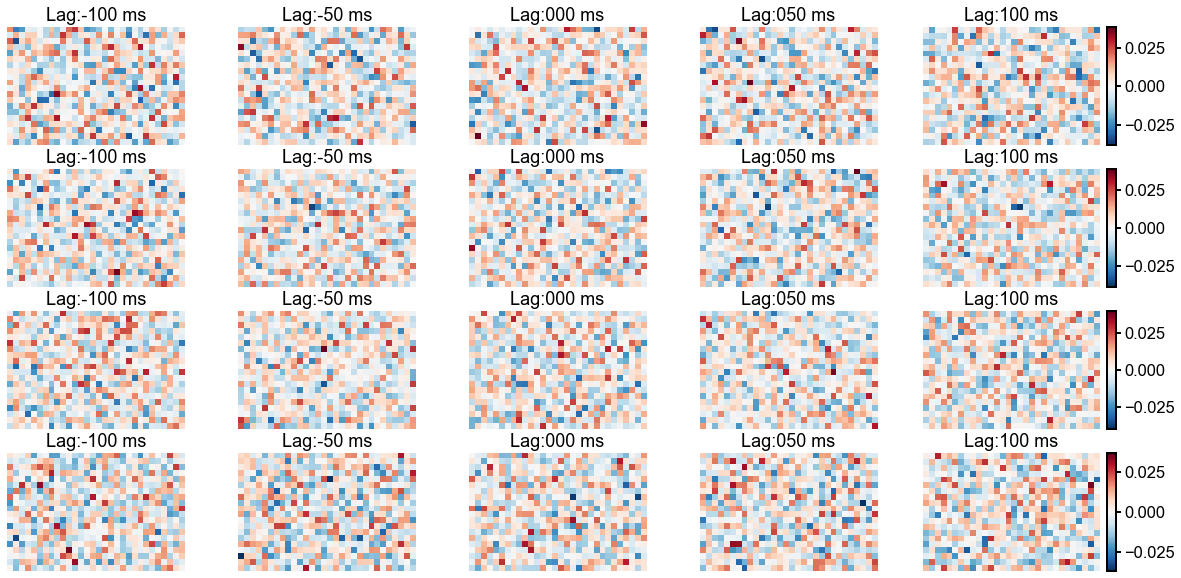

In [546]:
Msta = w_move[:,:-4].reshape((model_nsp.shape[-1],nt_glm_lag,len(titles))+nks)
fig, ax = plt.subplots(4,nt_glm_lag,figsize=(20,10))
for modeln in range(len(titles)):
    crange = np.max(np.abs(Msta[celln,:,modeln]))
    for n in range(nt_glm_lag):
        img = ax[modeln,n].imshow(Msta[celln,n,modeln],cmap='RdBu_r',vmin=-crange,vmax=crange)
        ax[modeln,n].axis('off')
        ax[modeln,n].set_title('Lag:{:03d} ms'.format(int(1000*lag_list[n]*model_dt)))
        ax[modeln,n].axis('off')
    add_colorbar(img)

In [429]:
##### Make PDF of All Cells #####
bin_length=40
do_shuffle = False
ncells=model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
for model_dt in [.05]: #
    data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=False,free_move=free_move, has_imu=free_move, has_mouse=False)
    locals().update(data)
    if do_shuffle:
        GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
    else:
        GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag))
    locals().update(GLM_Vis)
    ##### Explore Neurons #####
    colors = plt.cm.cool(np.linspace(0,1,4))
    clrs = ['blue','orange','green','red']
    # Initialize movement combinations
    titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
    titles_all = []
    for n in range(1,len(titles)+1):
        perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
        for ind in range(perms.shape[0]):
            titles_all.append('_'.join([t for t in titles[perms[ind]]]))

    # train_dgaze_p = train_dth + np.diff(train_gz,append=0)
    # train_dgaze_n = train_dth - np.diff(train_gz,append=0)
    # test_dgaze_p = test_dth + np.diff(test_gz,append=0)
    # test_dgaze_n = test_dth - np.diff(test_gz,append=0)
    move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],train_pitch[:,np.newaxis]))#, train_dth[:,np.newaxis],train_dphi[:,np.newaxis]))
    move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
    # move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))# test_dth[:,np.newaxis],test_dphi[:,np.newaxis]))
    model_move = np.hstack((model_th[:,np.newaxis],model_phi[:,np.newaxis],model_roll[:,np.newaxis],model_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
    model_move = model_move - np.mean(model_move,axis=0)
    move_test = move_test - np.mean(move_test,axis=0)
    
    # Create all tuning curves for plotting
    N_bins=10
    ncells = model_nsp.shape[-1]
    ax_ylims = np.zeros((model_nsp.shape[-1],len(titles)))
    tuning_curves = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
    tuning_stds = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
    var_ranges = np.zeros((len(titles),N_bins-1))
    for modeln in range(len(titles)):
        metric = move_test[:,modeln]
        tuning, tuning_std, var_range = tuning_curve(test_nsp, metric, N_bins=N_bins, model_dt=model_dt)
        tuning_curves[:,modeln] = tuning
        tuning_stds[:,modeln] = tuning_std
        ax_ylims[:,modeln] = np.max(tuning,axis=1)
        var_ranges[modeln] = var_range
        
    quartiles = np.arange(0,1.25,.25)
    if do_shuffle:
        pdf_name = FigPath/ 'VisMov_GLM_{}_dt{:03d}_T{:02d}_cellsummary_shuff.pdf'.format(model_type,int(model_dt*1000),nt_glm_lag)
    else:
        pdf_name = FigPath/ 'VisMov_GLM_{}_dt{:03d}_T{:02d}_cellsummary.pdf'.format(model_type,int(model_dt*1000),nt_glm_lag)
    with PdfPages(pdf_name) as pdf:
        for celln in tqdm(range(model_nsp.shape[1])):            
            fig, axs = plt.subplots(3,5, figsize=((35,15))) 
            gs = axs[0,0].get_gridspec()
            gs_sub = gs[0,:].subgridspec(1,nt_glm_lag)
            for ax in axs[0,:]:
                ax.remove()
            top_grid = np.zeros((nt_glm_lag),dtype=object)
            for ind in range(nt_glm_lag):
                top_grid[ind] = fig.add_subplot(gs_sub[0,ind])

            predcell = pred_all[:,celln]/model_dt
            nspcell = test_nsp[:,celln]/model_dt
            test_nsp_smooth=((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
            pred_smooth=((np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
            # Set up predicted spike range between 1-99th percentile
            stat_bins = 5
            pred_range = np.quantile(predcell,[.1,.9])
            test_nsp_range = np.quantile(nspcell,[.01,1])
            spike_percentiles = np.arange(0,1.25,.25)
            spike_percentiles[-1]=.99
            spk_percentile2 = np.arange(.125,1.125,.25)
            pred_rangelin = np.quantile(predcell,spike_percentiles)
            xbin_pts = np.quantile(predcell,spk_percentile2)
            stat_bins = len(pred_rangelin) #5


            axs[1,0].plot(np.arange(len(test_nsp_smooth))*model_dt,test_nsp_smooth,'k',label='test FR')
            axs[1,0].plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', label='pred FR')
            axs[1,0].set_xlabel('Time (s)')
            axs[1,0].set_ylabel('Firing Rate (spks/s)')
            axs[1,0].legend()
            axs[1,0].set_title('Smoothed FRs')

            crange = np.max(np.abs(sta_all[celln]))
            for n in range(nt_glm_lag):
                img = top_grid[n].imshow(sta_all[celln,n],cmap='RdBu_r',vmin=-crange,vmax=crange)
                top_grid[n].axis('off')
                top_grid[n].set_title('Lag:{:03d} ms'.format(int(1000*lag_list[n]*model_dt)))
                top_grid[n].axis('off')
            add_colorbar(img)

            # Eye Tuning Curve
            top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
            for i,modeln in enumerate(range(len(titles)-2)):
                metric = move_test[:,modeln]
                nranges = np.quantile(metric,quartiles)
                stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
                edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
                norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
                for m in range(len(nranges)-1):
                    axs[1,1].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
                #     axs[1,1].errorbar(var_ranges[modeln],tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln],label=titles[modeln],c=clrs[modeln],lw=4,elinewidth=3)
                axs[1,1].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

            axs[1,1].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.nanmax(tuning_stds,axis=(1,2))[celln])
            axs[1,1].set_xlim(-30,30)
            axs[1,1].set_xlabel('Angle ($ ^{\degree}$)')
            axs[1,1].set_ylabel('Spikes/s')
            axs[1,1].set_title('Eye Tuning Curves')
            lines = axs[1,1].get_lines()
            legend1 = axs[1,1].legend([lines[0]],[titles[0]],bbox_to_anchor=(1.01, .2), fontsize=12)
            legend2 = axs[1,1].legend([lines[1]],[titles[1]],bbox_to_anchor=(1.01, .9), fontsize=12)
            axs[1,1].add_artist(legend1)

            # Head Tuning Curves
            top_yaxs = np.max(ax_ylims[celln])+2*np.nanmax(tuning_stds[celln])
            for i, modeln in enumerate(range(2,len(titles))):
                metric = move_test[:,modeln]
            #     nranges = np.round(np.quantile(var_ranges[modeln],quartiles),decimals=1)
                nranges = np.round(np.quantile(metric,quartiles),decimals=1)
                stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
                edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
                norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
                for m in range(len(nranges)-1):
                    axs[1,2].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
            #     axs[1,2].errorbar(var_ranges[modeln], tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln], label=titles[modeln], c=clrs[modeln],lw=4,elinewidth=3)
                axs[1,2].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

            axs[1,2].set_ylim(bottom=0,top=top_yaxs)
            axs[1,2].set_xlim(-30,30)
            axs[1,2].set_xlabel('Angle ($ ^{\degree}$)')
            axs[1,2].set_ylabel('Spikes/s')
            axs[1,2].set_title('Head Tuning Curves')
            lines = axs[1,2].get_lines()
            legend1 = axs[1,2].legend([lines[0]],[titles[2]],bbox_to_anchor=(1.01, .2), fontsize=12)
            legend2 = axs[1,2].legend([lines[1]],[titles[3]],bbox_to_anchor=(1.01, .9), fontsize=12)
            axs[1,2].add_artist(legend1)

            # axs[1,2].legend(bbox_to_anchor=(1.01, 1), fontsize=12)


            # pred_rangelin = np.linspace(pred_range[0],pred_range[1],stat_bins)
            axs[1,3].scatter(pred_all[celln]/model_dt,test_nsp[celln]/model_dt,c='k',s=15)
            axs[1,3].plot(np.linspace(test_nsp_range[0],test_nsp_range[1]),np.linspace(test_nsp_range[0],test_nsp_range[1]),'k--',zorder=0)
            axs[1,3].set_xlabel('Predicted Spike Rate')
            axs[1,3].set_ylabel('Actual Spike Rate')
            cbar = add_colorbar(img)
            # cbar.set_label('count')

            if MovModel == 1:
                w_move = np.zeros((model_nsp.shape[-1],len(titles)))
            elif MovModel == 3:
                Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],nt_glm_lag,len(titles))+nks)
                w_move = w_move[:,-len(titles):]
            for modeln in range(len(titles)):
                axs[1,4].bar(modeln, w_move[celln,modeln], color=clrs[modeln])
                axs[1,4].set_xticks(np.arange(0,len(titles)))
                axs[1,4].set_xticklabels(titles)
                axs[1,4].set_ylabel('GLM Weight')


            mse_add = np.zeros((ncells,len(titles),len(quartiles)-1))
            mse_mult = np.zeros((ncells,len(titles),len(quartiles)-1))
            alpha_add = np.zeros((ncells,len(titles),len(quartiles)-1))
            alpha_mult = np.zeros((ncells,len(titles),len(quartiles)-1))

            traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
            traces_mean = np.zeros((ncells,len(titles),stat_bins-1)) # (model_type,quartile,FR)
            edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
            # df_traces = pd.DataFrame([],columns=['modeln','quartile','FR']) 
            for modeln in range(len(titles)):
                metric = move_test[:,modeln]
                nranges = np.quantile(metric,quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
                stat_all, edges, _ = binned_statistic(predcell,nspcell, statistic='mean',bins=pred_rangelin)
                edge_mids = xbin_pts#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                traces_mean[celln,modeln]=stat_all
                max_fr = np.max(stat_all)
            #     axs[1,modeln].set_xlim(0,pred_range[1]+np.std(pred_range))
            #     axs[1,modeln].set_ylim(0,np.max(stat)+np.std(stat))

                for n in range(len(nranges)-1):
                    ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
                    pred = predcell[ind]
                    sp = nspcell[ind]

                    stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
                    edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                    traces[celln,modeln,n]=stat_range
                    edges_all[celln,modeln,n]=edge_mids
                    res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr))
                    res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr))
                    mse_add[celln, modeln, n] = res_add.fun
                    mse_mult[celln, modeln, n] = res_mult.fun
                    alpha_add[celln, modeln, n] = res_add.x
                    alpha_mult[celln, modeln, n] = res_mult.x

                    axs[2,modeln].plot(edge_mids, stat_range,'.-', c=colors[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
                    axs[2,modeln].set_title('Metric: {}'.format(titles[modeln]), color=clrs[modeln])
                    axs[2,modeln].set_xlabel('Predicted Spike Rate')
                    axs[2,modeln].set_ylabel('Actual Spike Rate')

                lim_max = np.max(traces[celln,modeln])+1.5*np.std(traces_mean[celln,modeln])
                lim_min = np.min(traces[celln,modeln])-1.5*np.std(traces_mean[celln,modeln])
                lims = (0, lim_max) if (lim_min)<0 else (lim_min,lim_max) 
                axs[2,modeln].plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
                axs[2,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
                axs[2,modeln].legend(bbox_to_anchor=(1.01, 1), fontsize=12)
                axs[2,modeln].axis('equal')
            #     axs[2,modeln].set_xlim(left=0)
                axs[2,modeln].set(xlim=lims, ylim=lims)
            #     axs[2,modeln].set_xlim([0,xbin_pts[-1]])
                axs[2,modeln].set_ylim(bottom=0)

            dmodel = mse_add[celln]-mse_mult[celln]
            crange = np.max(np.abs(dmodel))
            im = axs[2,-1].imshow(dmodel,cmap='seismic',vmin=-crange,vmax=crange)
            axs[2,-1].set_yticks(np.arange(0,4))
            axs[2,-1].set_yticklabels(titles)
            axs[2,-1].set_ylabel('Movement Model')
            axs[2,-1].set_xticks(np.arange(0,4))
            axs[2,-1].set_xticklabels(['.25','.5','.75','1'])
            axs[2,-1].set_xlabel('Quantile Range')
            axs[2,-1].set_title('$MSE_{add}$ - $MSE_{mult}$')
            cbar = add_colorbar(im)

            plt.suptitle('Celln:{}, r2={:.03f}'.format(celln,r2_all[celln]),y=1,fontsize=30)
            plt.tight_layout()

            pdf.savefig()
            plt.close()

    # fig.savefig(FigPath/'CellSummary_N{}.png'.format(celln), facecolor='white', transparent=True)

Done Loading Aligned Data
TRAIN: 15628 TEST: 6698


  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

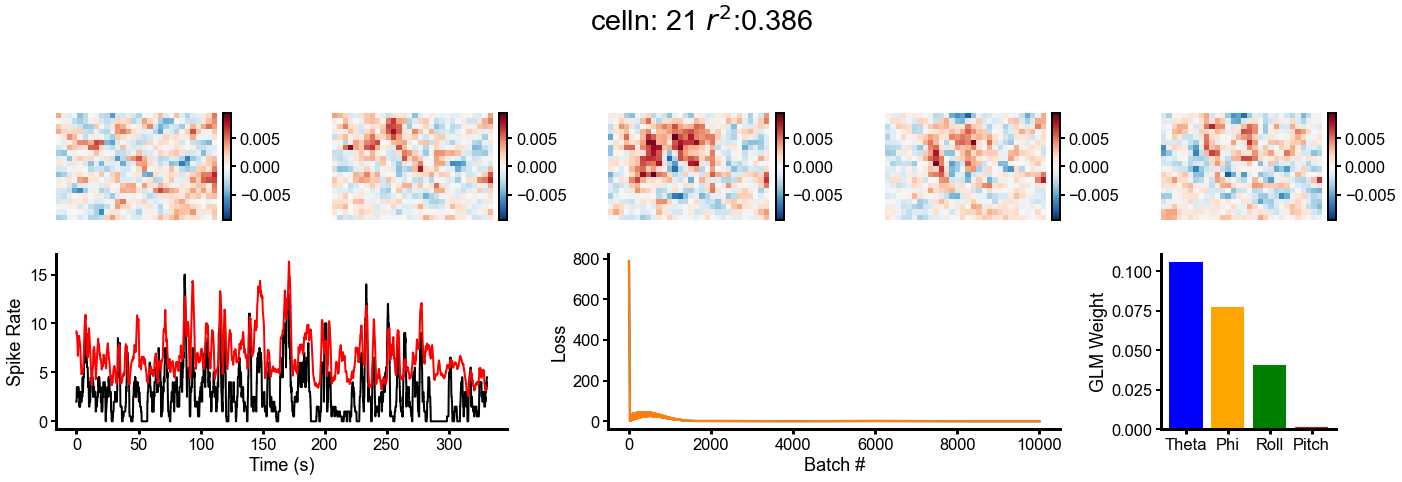

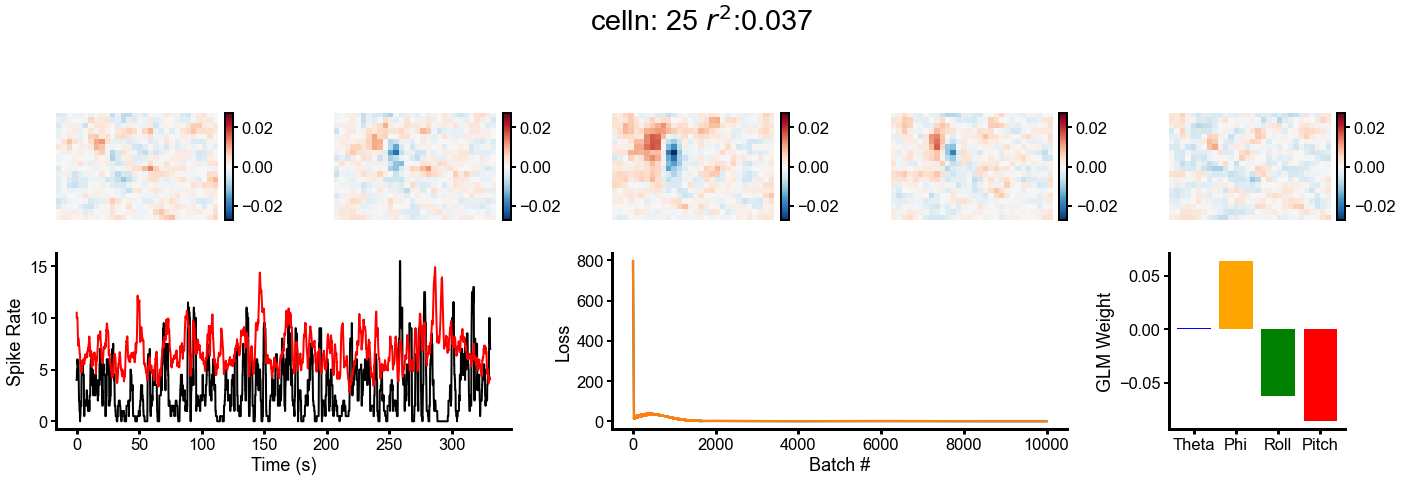

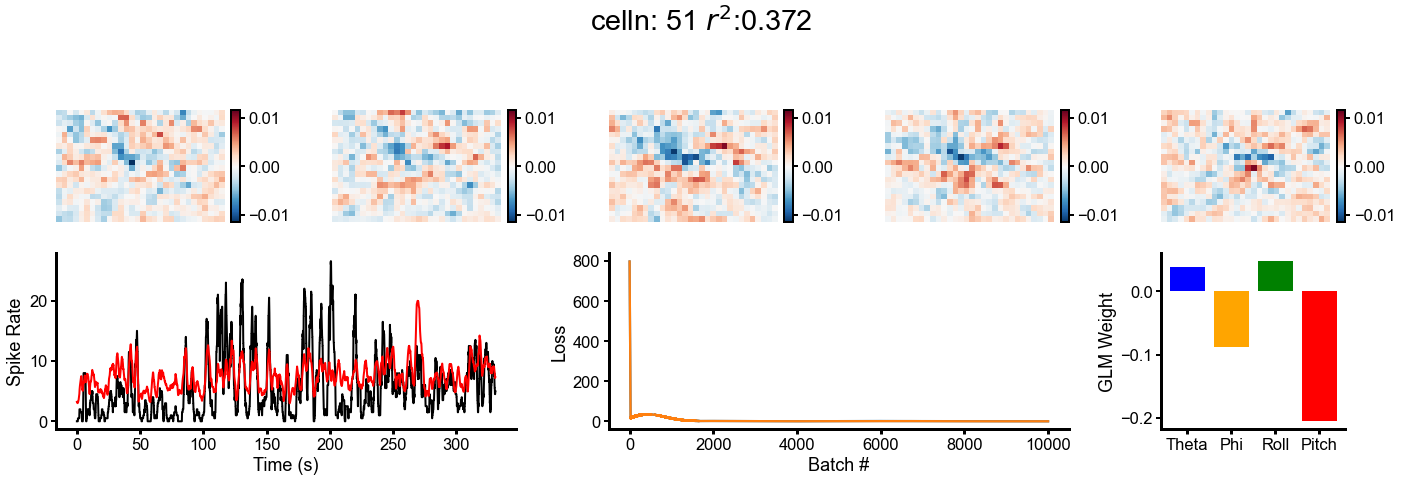

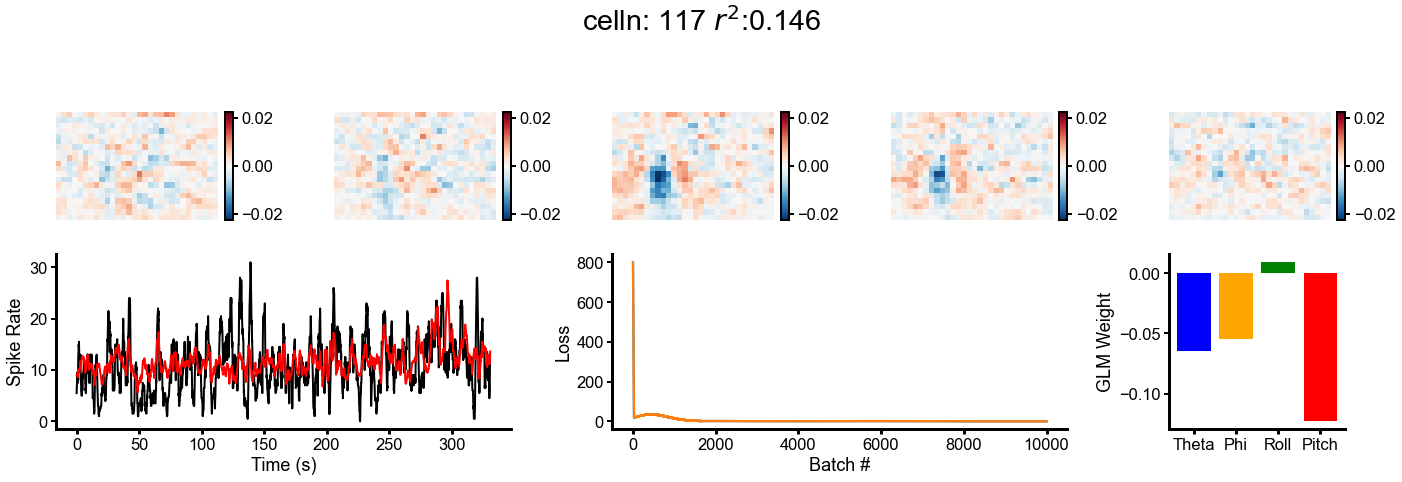

In [530]:
bin_length=40

for n, celln in enumerate(tqdm([21,25,51,117])):
    fig2 = plt.figure(constrained_layout=False, figsize=(20,7))
    spec2 = gridspec.GridSpec(ncols=nt_glm_lag, nrows=2, figure=fig2)
    axs = np.array([fig2.add_subplot(spec2[0, n]) for n in range(nt_glm_lag)])
    f2_ax6 = fig2.add_subplot(spec2[1, :nt_glm_lag//2])
    f2_ax7 = fig2.add_subplot(spec2[1, nt_glm_lag//2:-1])
    f2_ax8 = fig2.add_subplot(spec2[1, -1])
    crange = np.max(np.abs(sta_all[celln]))
    for n,ax in enumerate(axs):
        im = ax.imshow(sta_all[celln,n],'RdBu_r',vmin=-crange,vmax=crange)
        cbar = add_colorbar(im)
        ax.axis('off')

    sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    f2_ax6.plot(np.arange(len(sp_smooth))*model_dt,sp_smooth, 'k', lw=2)
    pred_smooth = ((np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    f2_ax6.plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', lw=2)
    f2_ax6.set_xlabel('Time (s)')
    f2_ax6.set_ylabel('Spike Rate')
    f2_ax7.plot(tloss_trace[:,celln])
    f2_ax7.plot(vloss_trace[:,celln])
    f2_ax7.set_xlabel('Batch #')
    f2_ax7.set_ylabel('Loss')
    r2 = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2
    for modeln in range(len(titles)):
        f2_ax8.bar(modeln, w_move[celln,modeln], color=clrs[modeln])
        f2_ax8.set_xticks(np.arange(0,len(titles)))
        f2_ax8.set_xticklabels(titles)
        f2_ax8.set_ylabel('GLM Weight')    
    plt.suptitle('celln: {} $r^2$:{:.03f}'.format(celln, r2))
    plt.tight_layout()

## Shuffle Comparison

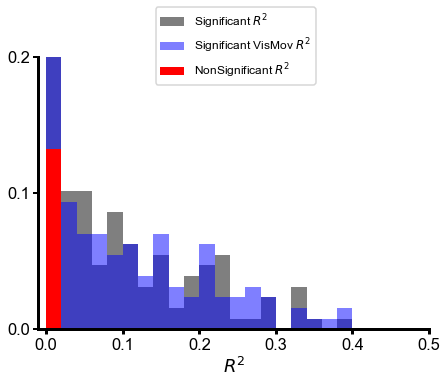

In [620]:
model_dt=.05
# for model_dt in [.025,.05,.1]:
GLM_VisMov_shuff = ioh5.load(save_dir/'GLM_{}_Data_Mov_dt{:03d}_T{:02d}_MovModel{:d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel))
GLM_VisMov_m0 = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag,0))
GLM_VisMov_m1 = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag,1))
GLM_VisMov_m2 = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag,2))
# GLM_VisMov_m3 = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag,3))


max_shuff = np.max(GLM_VisMov_shuff['r2_all']**2)
fig,ax = plt.subplots(1,1,figsize=(7,5))

sig = GLM_VisMov_m1['r2_all'][GLM_VisMov_m1['r2_all']>max_shuff]
non_sig = GLM_VisMov_m1['r2_all'][GLM_VisMov_m1['r2_all']<max_shuff]
non_sig_vm = GLM_VisMov_m2['r2_all'][GLM_VisMov_m2['r2_all']<max_shuff]

hbins=.02
count,edges = np.histogram(GLM_VisMov_m1['r2_all'],bins=np.arange(0,1,hbins))
count_m2,edges_m2 = np.histogram(GLM_VisMov_m2['r2_all'],bins=np.arange(0,1,hbins))
count_shuff,edges_shuff = np.histogram(non_sig,bins=np.arange(0,1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
edges_mid_m2 = np.array([(edges_m2[i]+edges_m2[i+1])/2 for i in range(len(edges_m2)-1)])
edges_mid_shuff = np.array([(edges_shuff[i]+edges_shuff[i+1])/2 for i in range(len(edges_shuff)-1)])
ax.bar(edges_mid, count/len(GLM_VisMov['r2_all']),color='k',width=hbins,alpha=.5, label='Significant $R^2$')
ax.bar(edges_mid_m2, count_m2/len(GLM_VisMov_m2['r2_all']),color='b',width=hbins,alpha=.5, label='Significant VisMov $R^2$')
ax.bar(edges_mid_shuff, count_shuff/len(GLM_VisMov['r2_all']),color='r',width=hbins,alpha=1, label='NonSignificant $R^2$')
ax.set_xlabel('$R^2$')
ax.set_yticks(np.arange(0,1,.1))
ax.set_yticklabels(np.round(np.arange(0,1,.1),decimals=3))
ax.set_xlim(-.01,.5)
ax.set_ylim(0,.2)
ax.legend(fontsize=12,loc=(.3,.9))

In [99]:
np.std((GLM_Vis_m0['r2_all'],GLM_Vis_m1['r2_all'],GLM_Vis_m2['r2_all']))

0.12321946872201307

In [103]:
GLM_VisMov_m0 = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag,0))
GLM_VisMov_m1 = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag,1))
GLM_VisMov_m2 = ioh5.load(save_dir/'GLM_{}_Data_VisMov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag,2))
r_vpm = GLM_VisMov_m1['r2_all']+GLM_VisMov_m0['r2_all']

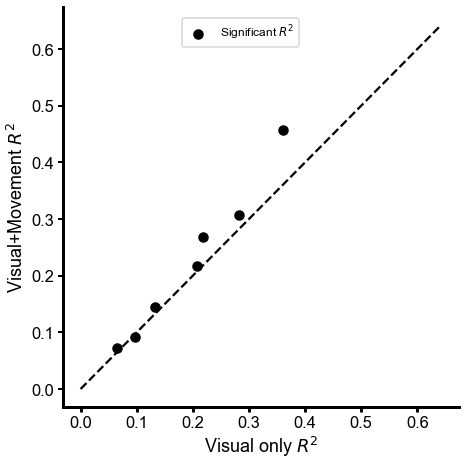

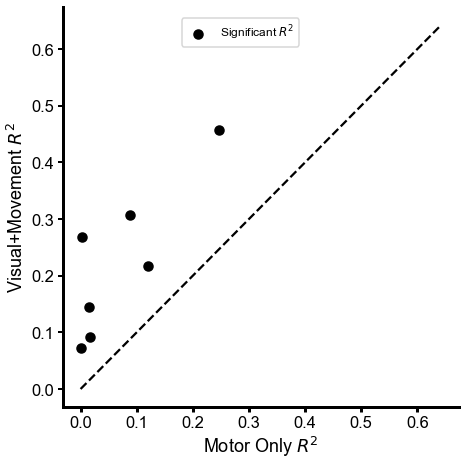

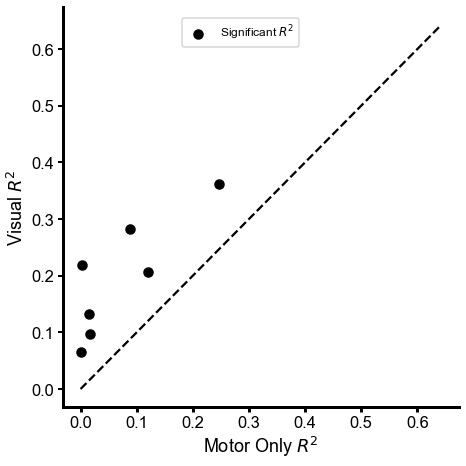

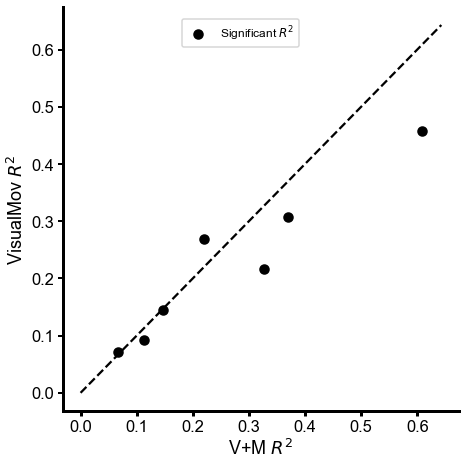

(raylet) ----------------------------------------
(raylet) Exception happened during processing of request from ('100.27.42.242', 40986)
(raylet) Traceback (most recent call last):
(raylet)   File "/home/seuss/anaconda3/envs/pytorch/lib/python3.8/socketserver.py", line 650, in process_request_thread
(raylet)     self.finish_request(request, client_address)
(raylet)   File "/home/seuss/anaconda3/envs/pytorch/lib/python3.8/socketserver.py", line 360, in finish_request
(raylet)     self.RequestHandlerClass(request, client_address, self)
(raylet)   File "/home/seuss/anaconda3/envs/pytorch/lib/python3.8/socketserver.py", line 720, in __init__
(raylet)     self.handle()
(raylet)   File "/home/seuss/anaconda3/envs/pytorch/lib/python3.8/wsgiref/simple_server.py", line 118, in handle
(raylet)     self.raw_requestline = self.rfile.readline(65537)
(raylet)   File "/home/seuss/anaconda3/envs/pytorch/lib/python3.8/socket.py", line 669, in readinto
(raylet)     return self._sock.recv_into(b)
(raylet

In [104]:
lim_max = np.max((GLM_Vis_m0['r2_all'],GLM_Vis_m1['r2_all'],GLM_Vis_m2['r2_all']))+1.5*np.std((GLM_Vis_m0['r2_all'],GLM_Vis_m1['r2_all'],GLM_Vis_m2['r2_all']))
lims = (0, lim_max)

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(GLM_VisMov_m1['r2_all'],GLM_VisMov_m2['r2_all'],c='k',label='Significant $R^2$')
# ax.scatter(non_sig,non_sig_vm,c='r', label='Nonsignificant $R^2$')
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.legend(fontsize=12,loc=(.3,.9))
ax.set_xlabel('Visual only $R^2$')
ax.set_ylabel('Visual+Movement $R^2$')
plt.tight_layout()
# fig.savefig(FigPath/'M1M2_R2_Comparison.png', facecolor='white', transparent=True)

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(GLM_VisMov_m0['r2_all'],GLM_VisMov_m2['r2_all'],c='k',label='Significant $R^2$')
# ax.scatter(non_sig,non_sig_vm,c='r', label='Nonsignificant $R^2$')
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.legend(fontsize=12,loc=(.3,.9))
ax.set_xlabel('Motor Only $R^2$')
ax.set_ylabel('Visual+Movement $R^2$')
plt.tight_layout()
# fig.savefig(FigPath/'M0M2_R2_Comparison.png', facecolor='white', transparent=True)


fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(GLM_VisMov_m0['r2_all'],GLM_VisMov_m1['r2_all'],c='k',label='Significant $R^2$')
# ax.scatter(non_sig,non_sig_vm,c='r', label='Nonsiagnificant $R^2$')
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.legend(fontsize=12,loc=(.3,.9))
ax.set_xlabel('Motor Only $R^2$')
ax.set_ylabel('Visual $R^2$')
plt.tight_layout()
# fig.savefig(FigPath/'M0M1_R2_Comparison.png', facecolor='white', transparent=True)

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(r_vpm,GLM_VisMov_m2['r2_all'],c='k',label='Significant $R^2$')
# ax.scatter(non_sig,non_sig_vm,c='r', label='Nonsiagnificant $R^2$')
ax.plot(np.linspace(lims[0],lims[1]),np.linspace(lims[0],lims[1]),'k--',zorder=0)
ax.legend(fontsize=12,loc=(.3,.9))
ax.set_xlabel('V+M $R^2$')
ax.set_ylabel('VisualMov $R^2$')
plt.tight_layout()
# fig.savefig(FigPath/'VPM_R2_Comparison.png', facecolor='white', transparent=True)


# Motor Only

In [604]:
lag_list = np.array([-2,-1,0,1,2]) #np.array([-1,0,1,2,3]) #,np.arange(minlag,maxlag,np.floor((maxlag-minlag)/nt_glm_lag).astype(int))
nt_glm_lag = len(lag_list)
print(lag_list,1000*lag_list*model_dt)
do_shuffle = False
model_type = 'Pytorch'


# for do_shuffle in [False,True]:
# Load Data
data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=True,free_move=free_move, has_imu=free_move, has_mouse=False)
locals().update(data)

# Initialize movement combinations
titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
titles_all = []
for n in range(1,len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))

# train_dgaze_p = train_dth + np.diff(train_gz,append=0)
# train_dgaze_n = train_dth - np.diff(train_gz,append=0)
# test_dgaze_p = test_dth + np.diff(test_gz,append=0)
# test_dgaze_n = test_dth - np.diff(test_gz,append=0)
move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],train_pitch[:,np.newaxis]))
move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis])) 
model_move = np.hstack((model_th[:,np.newaxis],model_phi[:,np.newaxis],model_roll[:,np.newaxis],model_pitch[:,np.newaxis]))
model_move = model_move - np.mean(model_move,axis=0)
move_test = move_test - np.mean(move_test,axis=0)

##### Start GLM Parallel Processing #####
nks = np.shape(train_vid)[1:]; nk = nks[0]*nks[1]*nt_glm_lag
n=4; ind=0
perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))

MovModel = 2
# Reshape data (video) into (T*n)xN array
rolled_vid = np.hstack([np.roll(model_vid_sm, nframes, axis=0) for nframes in lag_list]) # nt_glm_lag
if MovModel == 0:
    mx_train = move_train[:,perms[ind]]
    mx_test = move_test[:,perms[ind]]
    xtr = torch.from_numpy(mx_train.astype(np.float32)).to(device)
    xte = torch.from_numpy(mx_test.astype(np.float32)).to(device)    
    move_features = mx_train.shape[-1]
    nk = 0
elif MovModel == 1:
    x_train = rolled_vid[train_idx].reshape(len(train_idx),-1)
    x_test = rolled_vid[test_idx].reshape(len(test_idx),-1)
    move_features = None
elif MovModel == 2:
    x_train_m2 = np.concatenate((x_train,move_train[:,perms[ind]]),axis=1)
    x_test_m2 = np.concatenate((x_test,move_test[:,perms[ind]]),axis=1)
    xtr = torch.from_numpy(x_train_m2.astype(np.float32)).to(device)
    xte = torch.from_numpy(x_test_m2.astype(np.float32)).to(device)
    move_features = x_train_m2.shape[-1]-nk
elif MovModel == 3:
    x_train_m3 = np.hstack((x_train,np.hstack([x_train*move_train[:,modeln][:,np.newaxis] for modeln in np.arange(len(titles))]), move_train[:,perms[ind]]))
    x_test_m3 = np.hstack((x_test,np.hstack([x_test*move_test[:,modeln][:,np.newaxis] for modeln in np.arange(len(titles))]), move_test[:,perms[ind]]))
    xtr = torch.from_numpy(x_train_m3.astype(np.float32)).to(device)
    xte = torch.from_numpy(x_test_m3.astype(np.float32)).to(device)    
    move_features = x_train_m3.shape[-1]-nk

    
ytr = torch.from_numpy(train_nsp.astype(np.float32)).to(device)
yte = torch.from_numpy(test_nsp.astype(np.float32)).to(device)
print('move_features: {}'.format(move_features))

[-2 -1  0  1  2] [-100.  -50.    0.   50.  100.]
Done Loading Aligned Data
TRAIN: 15628 TEST: 6698
move_features: 4


In [606]:
input_size = xtr.shape[1]
output_size = ytr.shape[1]
reg_lam = 512
reg_alph = 10
l1 = PoissonGLM_VM(input_size,output_size,reg_lam=reg_lam,reg_alph=reg_alph,move_features=move_features).to(device)
if MovModel == 1:
    optimizer = optim.ASGD([{'params': [l1.weight, l1.bias]}, 
                           {'params': [l1.lam, l1.alpha,] , 'lr': .01},
                           ], lr=1e-3) 
else:
    optimizer = optim.ASGD([{'params': [l1.weight, l1.bias]}, 
                       {'params': [l1.lam, l1.alpha,l1.lam_m, l1.alpha_m] , 'lr': .01},
                       ], lr=1e-3) 
# optimizer = optim.ASGD(params=l1.parameters()) #
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1000)

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=[1e-4, .1], max_lr=[1e-3, 16], cycle_momentum=False)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=[0.001,], max_lr=[10], cycle_momentum=False)

lossfn = torch.nn.PoissonNLLLoss(log_input=True,reduction='mean')

Nbatches= 10000
vloss_trace = np.zeros((Nbatches,output_size))      
tloss_trace = np.zeros((Nbatches,output_size))      
early_stopping = EarlyStopping(patience=500,min_delta=.5)
# lam_grad = np.zeros((Nbatches,output_size))
for batchn in tqdm(np.arange(Nbatches)):
    out = l1(xtr)
    loss = l1.loss(out,ytr)
    pred = l1(xte)
    val_loss = l1.loss(pred,yte)
    vloss_trace[batchn] = val_loss.clone().cpu().detach().numpy()
    tloss_trace[batchn] = loss.clone().cpu().detach().numpy()
    optimizer.zero_grad()
    loss.backward(torch.ones_like(loss))
    optimizer.step()
    scheduler.step()
#     lam_grad[batchn]= l1.lam.grad.detach().cpu().numpy()
#     early_stopping(val_loss.item())
#     if early_stopping.early_stop:
#         break
pred_all = l1(xte).cpu().detach().numpy()
if MovModel != 0:
    sta_all = l1.weight.cpu().detach().numpy()[:,:(nk)].reshape((output_size,nt_glm_lag)+nks)
if MovModel != 1:
    w_move = l1.weight.cpu().detach().numpy()[:,(nk):]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [610]:
bin_length=40
r2_all = np.zeros(output_size)
for celln in range(output_size):
    sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    pred_smooth = ((np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    r2_all[celln] = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2

if MovModel == 0:
    GLM_Data = {'r2_all': r2_all,
                'spks_all': test_nsp,
                'pred_all': pred_all,
                'w_move': w_move}
elif MovModel == 1:
    GLM_Data = {'r2_all': r2_all,
                'sta_all': sta_all,
                'spks_all': test_nsp,
                'pred_all': pred_all,
               }
else:
    GLM_Data = {'r2_all': r2_all,
                'sta_all': sta_all,
                'spks_all': test_nsp,
                'pred_all': pred_all,
                'w_move': w_move}

if do_shuffle:
    save_datafile = save_dir/'GLM_{}_Data_Mov_dt{:03d}_T{:02d}_MovModel{:d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel)
else:
    save_datafile = save_dir/'GLM_{}_Data_Mov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag,MovModel)
ioh5.save(save_datafile, GLM_Data)
print(save_datafile)

/home/seuss/Research/SensoryMotorPred_Data/data/070921/J553RT/fm1/GLM_Pytorch_Data_Mov_dt050_T05_MovModel0.h5


## Plotting

In [89]:
bin_length=40
data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=False,free_move=free_move, has_imu=free_move, has_mouse=False)
locals().update(data)
if do_shuffle:
    save_datafile = save_dir/'GLM_{}_Data_Mov_dt{:03d}_T{:02d}_MovModel{:d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel)
else:
    save_datafile = save_dir/'GLM_{}_Data_Mov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag,MovModel)
GLM_Vis = ioh5.load(save_datafile)
locals().update(GLM_Vis)
##### Explore Neurons #####
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
# Initialize movement combinations
titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
titles_all = []
for n in range(1,len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))

# train_dgaze_p = train_dth + np.diff(train_gz,append=0)
# train_dgaze_n = train_dth - np.diff(train_gz,append=0)
# test_dgaze_p = test_dth + np.diff(test_gz,append=0)
# test_dgaze_n = test_dth - np.diff(test_gz,append=0)
move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],train_pitch[:,np.newaxis]))#, train_dth[:,np.newaxis],train_dphi[:,np.newaxis]))
move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
# move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))# test_dth[:,np.newaxis],test_dphi[:,np.newaxis]))
model_move = np.hstack((model_th[:,np.newaxis],model_phi[:,np.newaxis],model_roll[:,np.newaxis],model_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
model_move = model_move - np.mean(model_move,axis=0)
move_test = move_test - np.mean(move_test,axis=0)
# Create all tuning curves for plotting
N_bins=10
ncells = model_nsp.shape[-1]
ax_ylims = np.zeros((model_nsp.shape[-1],len(titles)))
tuning_curves = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
tuning_stds = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
var_ranges = np.zeros((len(titles),N_bins-1))
for modeln in range(len(titles)):
    metric = move_test[:,modeln]
    tuning, tuning_std, var_range = tuning_curve(test_nsp, metric, N_bins=N_bins, model_dt=model_dt)
    tuning_curves[:,modeln] = tuning
    tuning_stds[:,modeln] = tuning_std
    ax_ylims[:,modeln] = np.max(tuning,axis=1)
    var_ranges[modeln] = var_range

Done Loading Aligned Data
TRAIN: 50116 TEST: 21477


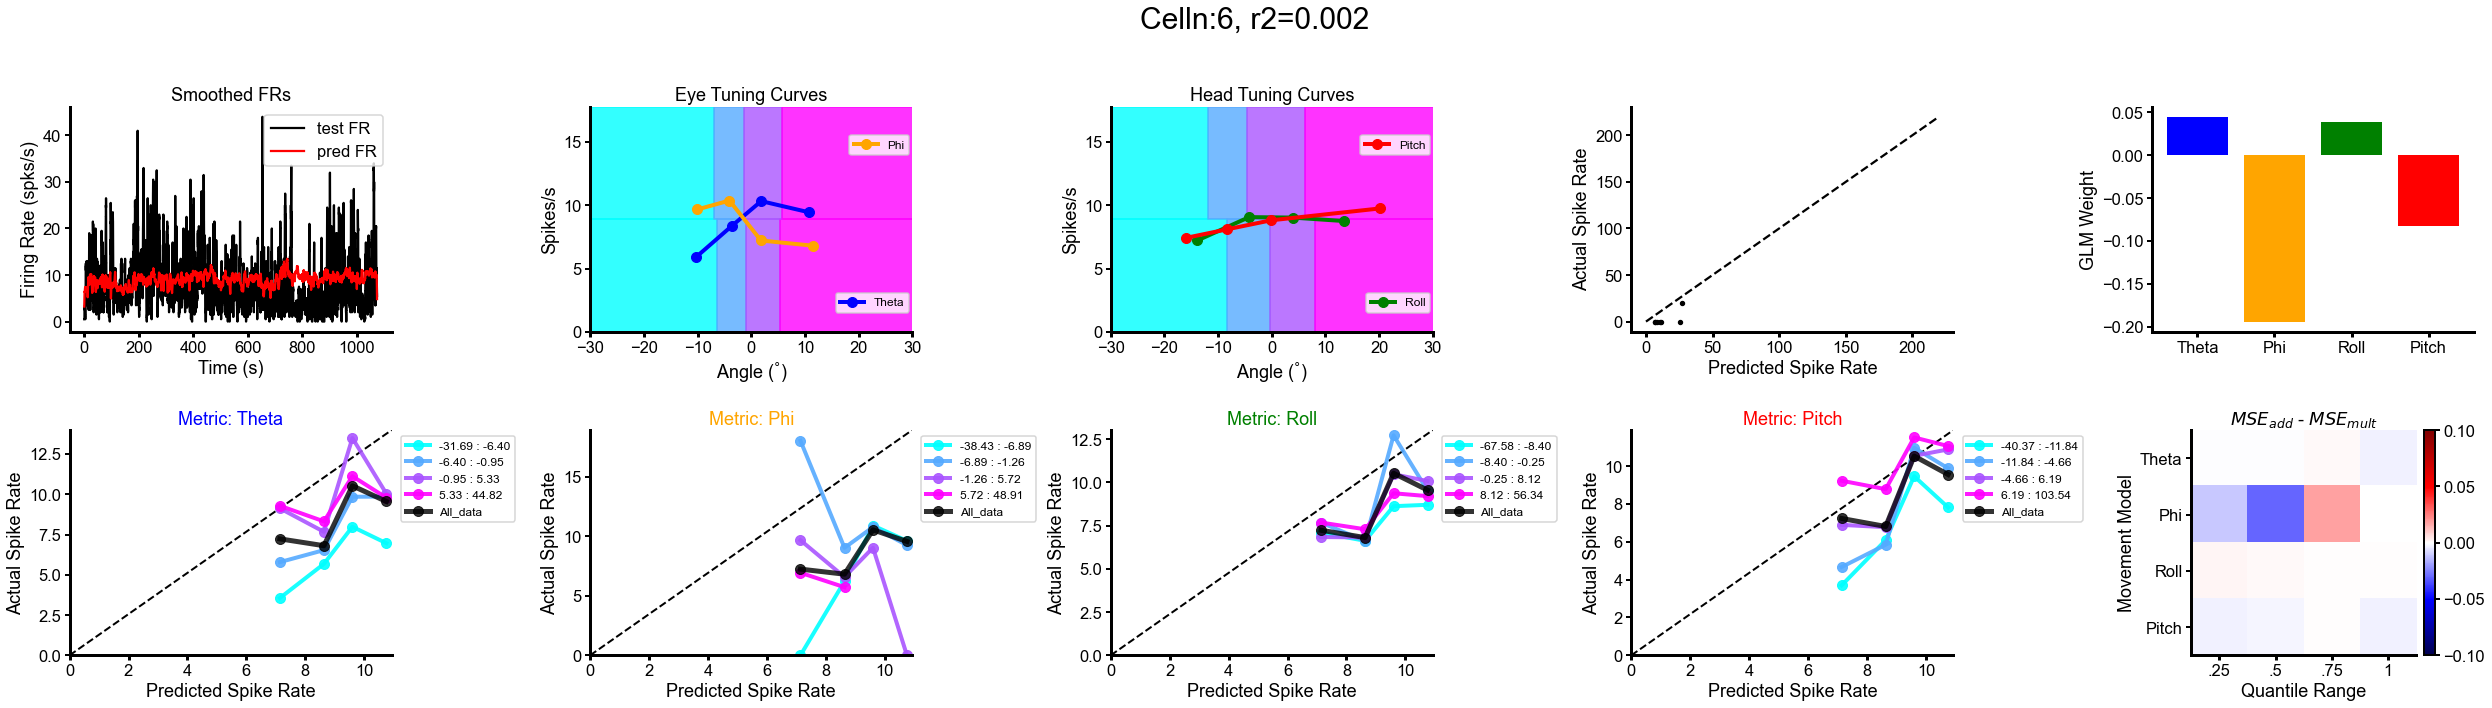

In [92]:
celln = 6 #np.argmax(mr2)
bin_length = 40
ncells=model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
quartiles = np.arange(0,1.25,.25)

fig, axs = plt.subplots(2,5, figsize=((35,10))) 

predcell = pred_all[:,celln]/model_dt
nspcell = test_nsp[:,celln]/model_dt
test_nsp_smooth=(np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
pred_smooth=(np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
# Set up predicted spike range between 1-99th percentile
stat_bins = 5
pred_range = np.quantile(predcell,[.1,.9])
test_nsp_range = np.quantile(nspcell,[.01,1])
spike_percentiles = np.arange(0,1.25,.25)
spike_percentiles[-1]=.99
spk_percentile2 = np.arange(.125,1.125,.25)
pred_rangelin = np.quantile(predcell,spike_percentiles)
xbin_pts = np.quantile(predcell,spk_percentile2)
stat_bins = len(pred_rangelin) #5


axs[0,0].plot(np.arange(len(test_nsp_smooth))*model_dt,test_nsp_smooth,'k',label='test FR')
axs[0,0].plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', label='pred FR')
axs[0,0].set_xlabel('Time (s)')
axs[0,0].set_ylabel('Firing Rate (spks/s)')
axs[0,0].legend()
axs[0,0].set_title('Smoothed FRs')

# Eye Tuning Curve
top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
for i,modeln in enumerate(range(len(titles)-2)):
    metric = move_test[:,modeln]
    nranges = np.quantile(metric,quartiles)
    stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
    norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
    for m in range(len(nranges)-1):
        axs[0,1].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
    #     axs[0,1].errorbar(var_ranges[modeln],tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln],label=titles[modeln],c=clrs[modeln],lw=4,elinewidth=3)
    axs[0,1].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

axs[0,1].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.max(tuning_stds,axis=(1,2))[celln])
axs[0,1].set_xlim(-30,30)
axs[0,1].set_xlabel('Angle ($ ^{\degree}$)')
axs[0,1].set_ylabel('Spikes/s')
axs[0,1].set_title('Eye Tuning Curves')
lines = axs[0,1].get_lines()
legend1 = axs[0,1].legend([lines[0]],[titles[0]],bbox_to_anchor=(1.01, .2), fontsize=12)
legend2 = axs[0,1].legend([lines[1]],[titles[1]],bbox_to_anchor=(1.01, .9), fontsize=12)
axs[0,1].add_artist(legend1)

# Head Tuning Curves
top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
for i, modeln in enumerate(range(2,len(titles))):
    metric = move_test[:,modeln]
#     nranges = np.round(np.quantile(var_ranges[modeln],quartiles),decimals=1)
    nranges = np.round(np.quantile(metric,quartiles),decimals=1)
    stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
    edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
    norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
    for m in range(len(nranges)-1):
        axs[0,2].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
#     axs[0,2].errorbar(var_ranges[modeln], tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln], label=titles[modeln], c=clrs[modeln],lw=4,elinewidth=3)
    axs[0,2].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

axs[0,2].set_ylim(bottom=0,top=top_yaxs)
axs[0,2].set_xlim(-30,30)
axs[0,2].set_xlabel('Angle ($ ^{\degree}$)')
axs[0,2].set_ylabel('Spikes/s')
axs[0,2].set_title('Head Tuning Curves')
lines = axs[0,2].get_lines()
legend1 = axs[0,2].legend([lines[0]],[titles[2]],bbox_to_anchor=(1.01, .2), fontsize=12)
legend2 = axs[0,2].legend([lines[1]],[titles[3]],bbox_to_anchor=(1.01, .9), fontsize=12)
axs[0,2].add_artist(legend1)

# axs[0,2].legend(bbox_to_anchor=(1.01, 1), fontsize=12)


# pred_rangelin = np.linspace(pred_range[0],pred_range[1],stat_bins)
axs[0,3].scatter(pred_all[celln]/model_dt,test_nsp[celln]/model_dt,c='k',s=15)
axs[0,3].plot(np.linspace(test_nsp_range[0],test_nsp_range[1]),np.linspace(test_nsp_range[0],test_nsp_range[1]),'k--',zorder=0)
axs[0,3].set_xlabel('Predicted Spike Rate')
axs[0,3].set_ylabel('Actual Spike Rate')
cbar = add_colorbar(img)
# cbar.set_label('count')

if MovModel == 1:
    w_move = np.zeros((model_nsp.shape[-1],len(titles)))
elif MovModel == 3:
    Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],nt_glm_lag,len(titles))+nks)
    w_move = w_move[:,-len(titles):]
for modeln in range(len(titles)):
    axs[0,4].bar(modeln, w_move[celln,modeln], color=clrs[modeln])
    axs[0,4].set_xticks(np.arange(0,len(titles)))
    axs[0,4].set_xticklabels(titles)
    axs[0,4].set_ylabel('GLM Weight')


mse_add = np.zeros((ncells,len(titles),len(quartiles)-1))
mse_mult = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_add = np.zeros((ncells,len(titles),len(quartiles)-1))
alpha_mult = np.zeros((ncells,len(titles),len(quartiles)-1))

traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
traces_mean = np.zeros((ncells,len(titles),stat_bins-1)) # (model_type,quartile,FR)
edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
# df_traces = pd.DataFrame([],columns=['modeln','quartile','FR']) 
for modeln in range(len(titles)):
    metric = move_test[:,modeln]
    nranges = np.quantile(metric,quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
    stat_all, edges, _ = binned_statistic(predcell,nspcell, statistic='mean',bins=pred_rangelin)
    edge_mids = xbin_pts#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
    traces_mean[celln,modeln]=stat_all
    max_fr = np.max(stat_all)
#     axs[0,modeln].set_xlim(0,pred_range[1]+np.std(pred_range))
#     axs[0,modeln].set_ylim(0,np.max(stat)+np.std(stat))

    for n in range(len(nranges)-1):
        ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
        pred = predcell[ind]
        sp = nspcell[ind]

        stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
        edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
        traces[celln,modeln,n]=stat_range
        edges_all[celln,modeln,n]=edge_mids
        res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr))
        res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr))
        mse_add[celln, modeln, n] = res_add.fun
        mse_mult[celln, modeln, n] = res_mult.fun
        alpha_add[celln, modeln, n] = res_add.x
        alpha_mult[celln, modeln, n] = res_mult.x

        axs[1,modeln].plot(edge_mids, stat_range,'.-', c=colors[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
        axs[1,modeln].set_title('Metric: {}'.format(titles[modeln]), color=clrs[modeln])
        axs[1,modeln].set_xlabel('Predicted Spike Rate')
        axs[1,modeln].set_ylabel('Actual Spike Rate')
    
    axs[1,modeln].plot([0, 1], [0, 1], 'k--', transform=axs[1,modeln].transAxes, lw=2, zorder=0)
    axs[1,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
    axs[1,modeln].legend(bbox_to_anchor=(1.01, 1), fontsize=12)
#     axs[1,modeln].axis('equal')
    axs[1,modeln].set_xlim(left=0)
#     axs[1,modeln].set(xlim=lims, ylim=lims)
#     axs[1,modeln].set_xlim([0,xbin_pts[-1]])
    axs[1,modeln].set_ylim(bottom=0)

dmodel = mse_add[celln]-mse_mult[celln]
crange = np.max(np.abs(dmodel))
im = axs[1,-1].imshow(dmodel,cmap='seismic',vmin=-crange,vmax=crange)
axs[1,-1].set_yticks(np.arange(0,4))
axs[1,-1].set_yticklabels(titles)
axs[1,-1].set_ylabel('Movement Model')
axs[1,-1].set_xticks(np.arange(0,4))
axs[1,-1].set_xticklabels(['.25','.5','.75','1'])
axs[1,-1].set_xlabel('Quantile Range')
axs[1,-1].set_title('$MSE_{add}$ - $MSE_{mult}$')
cbar = add_colorbar(im)

plt.suptitle('Celln:{}, r2={:.03f}'.format(celln,r2_all[celln]),y=1,fontsize=30)
plt.tight_layout()


# fig.savefig(FigPath/'CellSummary_N{}_T{:02d}.png'.format(celln,nt_glm_lag), facecolor='white', transparent=True)

In [ ]:
##### Make PDF of All Cells #####
bin_length=40
do_shuffle = False
ncells=model_nsp.shape[-1]
colors = plt.cm.cool(np.linspace(0,1,4))
clrs = ['blue','orange','green','red']
for model_dt in [.05]: #
    data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=False,free_move=free_move, has_imu=free_move, has_mouse=False)
    locals().update(data)
    if do_shuffle:
        GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_Mov_dt{:03d}_T{:02d}_MovModel{:d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel))
    else:
        GLM_Vis = ioh5.load(save_dir/'GLM_{}_Data_Mov_dt{:03d}_T{:02d}_MovModel{:d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag,MovModel))
    locals().update(GLM_Vis)
    ##### Explore Neurons #####
    colors = plt.cm.cool(np.linspace(0,1,4))
    clrs = ['blue','orange','green','red']
    # Initialize movement combinations
    titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
    titles_all = []
    for n in range(1,len(titles)+1):
        perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
        for ind in range(perms.shape[0]):
            titles_all.append('_'.join([t for t in titles[perms[ind]]]))

    # train_dgaze_p = train_dth + np.diff(train_gz,append=0)
    # train_dgaze_n = train_dth - np.diff(train_gz,append=0)
    # test_dgaze_p = test_dth + np.diff(test_gz,append=0)
    # test_dgaze_n = test_dth - np.diff(test_gz,append=0)
    move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],train_pitch[:,np.newaxis]))#, train_dth[:,np.newaxis],train_dphi[:,np.newaxis]))
    move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
    # move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))# test_dth[:,np.newaxis],test_dphi[:,np.newaxis]))
    model_move = np.hstack((model_th[:,np.newaxis],model_phi[:,np.newaxis],model_roll[:,np.newaxis],model_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
    model_move = model_move - np.mean(model_move,axis=0)
    move_test = move_test - np.mean(move_test,axis=0)
    
    # Create all tuning curves for plotting
    N_bins=10
    ncells = model_nsp.shape[-1]
    ax_ylims = np.zeros((model_nsp.shape[-1],len(titles)))
    tuning_curves = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
    tuning_stds = np.zeros((model_nsp.shape[-1],len(titles),N_bins-1))
    var_ranges = np.zeros((len(titles),N_bins-1))
    for modeln in range(len(titles)):
        metric = move_test[:,modeln]
        tuning, tuning_std, var_range = tuning_curve(test_nsp, metric, N_bins=N_bins, model_dt=model_dt)
        tuning_curves[:,modeln] = tuning
        tuning_stds[:,modeln] = tuning_std
        ax_ylims[:,modeln] = np.max(tuning,axis=1)
        var_ranges[modeln] = var_range
        
    quartiles = np.arange(0,1.25,.25)
    if do_shuffle:
        pdf_name = FigPath/ 'VisMov_GLM_{}_dt{:03d}_T{:02d}_cellsummary_shuff.pdf'.format(model_type,int(model_dt*1000),nt_glm_lag)
    else:
        pdf_name = FigPath/ 'VisMov_GLM_{}_dt{:03d}_T{:02d}_cellsummary.pdf'.format(model_type,int(model_dt*1000),nt_glm_lag)
    with PdfPages(pdf_name) as pdf:
        for celln in tqdm(range(model_nsp.shape[1])):            

            fig, axs = plt.subplots(2,5, figsize=((35,10))) 

            predcell = pred_all[:,celln]/model_dt
            nspcell = test_nsp[:,celln]/model_dt
            test_nsp_smooth=(np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
            pred_smooth=(np.convolve(pred_all[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt)
            # Set up predicted spike range between 1-99th percentile
            stat_bins = 5
            pred_range = np.quantile(predcell,[.1,.9])
            test_nsp_range = np.quantile(nspcell,[.01,1])
            spike_percentiles = np.arange(0,1.25,.25)
            spike_percentiles[-1]=.99
            spk_percentile2 = np.arange(.125,1.125,.25)
            pred_rangelin = np.quantile(predcell,spike_percentiles)
            xbin_pts = np.quantile(predcell,spk_percentile2)
            stat_bins = len(pred_rangelin) #5


            axs[0,0].plot(np.arange(len(test_nsp_smooth))*model_dt,test_nsp_smooth,'k',label='test FR')
            axs[0,0].plot(np.arange(len(pred_smooth))*model_dt,pred_smooth,'r', label='pred FR')
            axs[0,0].set_xlabel('Time (s)')
            axs[0,0].set_ylabel('Firing Rate (spks/s)')
            axs[0,0].legend()
            axs[0,0].set_title('Smoothed FRs')

            # Eye Tuning Curve
            top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
            for i,modeln in enumerate(range(len(titles)-2)):
                metric = move_test[:,modeln]
                nranges = np.quantile(metric,quartiles)
                stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
                edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
                norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
                for m in range(len(nranges)-1):
                    axs[0,1].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
                #     axs[0,1].errorbar(var_ranges[modeln],tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln],label=titles[modeln],c=clrs[modeln],lw=4,elinewidth=3)
                axs[0,1].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

            axs[0,1].set_ylim(bottom=0,top=np.max(ax_ylims,axis=1)[celln]+2*np.max(tuning_stds,axis=(1,2))[celln])
            axs[0,1].set_xlim(-30,30)
            axs[0,1].set_xlabel('Angle ($ ^{\degree}$)')
            axs[0,1].set_ylabel('Spikes/s')
            axs[0,1].set_title('Eye Tuning Curves')
            lines = axs[0,1].get_lines()
            legend1 = axs[0,1].legend([lines[0]],[titles[0]],bbox_to_anchor=(1.01, .2), fontsize=12)
            legend2 = axs[0,1].legend([lines[1]],[titles[1]],bbox_to_anchor=(1.01, .9), fontsize=12)
            axs[0,1].add_artist(legend1)

            # Head Tuning Curves
            top_yaxs = np.max(ax_ylims[celln])+2*np.max(tuning_stds[celln])
            for i, modeln in enumerate(range(2,len(titles))):
                metric = move_test[:,modeln]
            #     nranges = np.round(np.quantile(var_ranges[modeln],quartiles),decimals=1)
                nranges = np.round(np.quantile(metric,quartiles),decimals=1)
                stat_range, edges, _ = binned_statistic(metric,test_nsp[:,celln],statistic='mean',bins=nranges)
                edge_mids = np.quantile(metric,spk_percentile2)#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                cmap = mpl.colors.ListedColormap(colors, N=colors.shape[0])
                norm = mpl.colors.BoundaryNorm(boundaries=np.floor(nranges), ncolors=len(cmap.colors))
                for m in range(len(nranges)-1):
                    axs[0,2].axvspan(nranges[m], nranges[m+1],ymin=i*1/2,ymax=(i+1)*1/2,alpha=0.8, color=colors[m],zorder=0)
            #     axs[0,2].errorbar(var_ranges[modeln], tuning_curves[celln,modeln], yerr=tuning_stds[celln,modeln], label=titles[modeln], c=clrs[modeln],lw=4,elinewidth=3)
                axs[0,2].plot(edge_mids,stat_range/model_dt,'.-', ms=20, lw=4,c=clrs[modeln])

            axs[0,2].set_ylim(bottom=0,top=top_yaxs)
            axs[0,2].set_xlim(-30,30)
            axs[0,2].set_xlabel('Angle ($ ^{\degree}$)')
            axs[0,2].set_ylabel('Spikes/s')
            axs[0,2].set_title('Head Tuning Curves')
            lines = axs[0,2].get_lines()
            legend1 = axs[0,2].legend([lines[0]],[titles[2]],bbox_to_anchor=(1.01, .2), fontsize=12)
            legend2 = axs[0,2].legend([lines[1]],[titles[3]],bbox_to_anchor=(1.01, .9), fontsize=12)
            axs[0,2].add_artist(legend1)

            # axs[0,2].legend(bbox_to_anchor=(1.01, 1), fontsize=12)


            # pred_rangelin = np.linspace(pred_range[0],pred_range[1],stat_bins)
            axs[0,3].scatter(pred_all[celln]/model_dt,test_nsp[celln]/model_dt,c='k',s=15)
            axs[0,3].plot(np.linspace(test_nsp_range[0],test_nsp_range[1]),np.linspace(test_nsp_range[0],test_nsp_range[1]),'k--',zorder=0)
            axs[0,3].set_xlabel('Predicted Spike Rate')
            axs[0,3].set_ylabel('Actual Spike Rate')
            cbar = add_colorbar(img)
            # cbar.set_label('count')

            if MovModel == 1:
                w_move = np.zeros((model_nsp.shape[-1],len(titles)))
            elif MovModel == 3:
                Msta = w_move[:,:-len(titles)].reshape((model_nsp.shape[-1],nt_glm_lag,len(titles))+nks)
                w_move = w_move[:,-len(titles):]
            for modeln in range(len(titles)):
                axs[0,4].bar(modeln, w_move[celln,modeln], color=clrs[modeln])
                axs[0,4].set_xticks(np.arange(0,len(titles)))
                axs[0,4].set_xticklabels(titles)
                axs[0,4].set_ylabel('GLM Weight')


            mse_add = np.zeros((ncells,len(titles),len(quartiles)-1))
            mse_mult = np.zeros((ncells,len(titles),len(quartiles)-1))
            alpha_add = np.zeros((ncells,len(titles),len(quartiles)-1))
            alpha_mult = np.zeros((ncells,len(titles),len(quartiles)-1))

            traces = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
            traces_mean = np.zeros((ncells,len(titles),stat_bins-1)) # (model_type,quartile,FR)
            edges_all = np.zeros((ncells,len(titles),len(quartiles)-1,stat_bins-1)) # (model_type,quartile,FR)
            # df_traces = pd.DataFrame([],columns=['modeln','quartile','FR']) 
            for modeln in range(len(titles)):
                metric = move_test[:,modeln]
                nranges = np.quantile(metric,quartiles)# np.linspace(np.nanmean(metric)-2*np.nanstd(metric), np.nanmean(metric)+2*np.nanstd(metric),N_bins)
                stat_all, edges, _ = binned_statistic(predcell,nspcell, statistic='mean',bins=pred_rangelin)
                edge_mids = xbin_pts#np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                traces_mean[celln,modeln]=stat_all
                max_fr = np.max(stat_all)
            #     axs[0,modeln].set_xlim(0,pred_range[1]+np.std(pred_range))
            #     axs[0,modeln].set_ylim(0,np.max(stat)+np.std(stat))

                for n in range(len(nranges)-1):
                    ind = np.where(((metric<=nranges[n+1])&(metric>nranges[n])))[0]
                    pred = predcell[ind]
                    sp = nspcell[ind]

                    stat_range, edges, _ = binned_statistic(pred, sp, statistic='mean',bins=pred_rangelin)
                    edge_mids = xbin_pts #np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
                    traces[celln,modeln,n]=stat_range
                    edges_all[celln,modeln,n]=edge_mids
                    res_add = minimize_scalar(f_add,args=(stat_range/max_fr, stat_all/max_fr))
                    res_mult = minimize_scalar(f_mult,args=(stat_range/max_fr, stat_all/max_fr))
                    mse_add[celln, modeln, n] = res_add.fun
                    mse_mult[celln, modeln, n] = res_mult.fun
                    alpha_add[celln, modeln, n] = res_add.x
                    alpha_mult[celln, modeln, n] = res_mult.x

                    axs[1,modeln].plot(edge_mids, stat_range,'.-', c=colors[n],label='{:.02f} : {:.02f}'.format(nranges[n],nranges[n+1]),lw=4,ms=20,alpha=.9)
                    axs[1,modeln].set_title('Metric: {}'.format(titles[modeln]), color=clrs[modeln])
                    axs[1,modeln].set_xlabel('Predicted Spike Rate')
                    axs[1,modeln].set_ylabel('Actual Spike Rate')

                axs[1,modeln].plot([0, 1], [0, 1], 'k--', transform=axs[1,modeln].transAxes, lw=2, zorder=0)
                axs[1,modeln].plot(edge_mids, stat_all,'.-', c='k', lw=5, ms=20, label='All_data', alpha=.8)
                axs[1,modeln].legend(bbox_to_anchor=(1.01, 1), fontsize=12)
            #     axs[1,modeln].axis('equal')
                axs[1,modeln].set_xlim(left=0)
            #     axs[1,modeln].set(xlim=lims, ylim=lims)
            #     axs[1,modeln].set_xlim([0,xbin_pts[-1]])
                axs[1,modeln].set_ylim(bottom=0)

            dmodel = mse_add[celln]-mse_mult[celln]
            crange = np.max(np.abs(dmodel))
            im = axs[1,-1].imshow(dmodel,cmap='seismic',vmin=-crange,vmax=crange)
            axs[1,-1].set_yticks(np.arange(0,4))
            axs[1,-1].set_yticklabels(titles)
            axs[1,-1].set_ylabel('Movement Model')
            axs[1,-1].set_xticks(np.arange(0,4))
            axs[1,-1].set_xticklabels(['.25','.5','.75','1'])
            axs[1,-1].set_xlabel('Quantile Range')
            axs[1,-1].set_title('$MSE_{add}$ - $MSE_{mult}$')
            cbar = add_colorbar(im)

            plt.suptitle('Celln:{}, r2={:.03f}'.format(celln,r2_all[celln]),y=1,fontsize=30)
            plt.tight_layout()

            pdf.savefig()
            plt.close()

    # fig.savefig(FigPath/'CellSummary_N{}.png'.format(celln), facecolor='white', transparent=True)

## Shuffle Comparison

<BarContainer object of 49 artists>

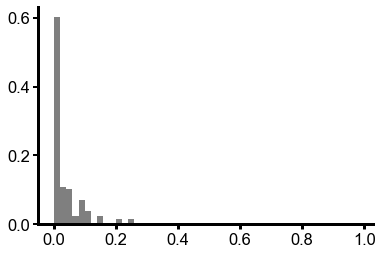

In [612]:
count,edges = np.histogram(r2_all,bins=np.arange(0,1,hbins))

edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
plt.bar(edges_mid, count/len(GLM_Vis['r2_all']),color='k',width=hbins,alpha=.5, label='Significant $R^2$')


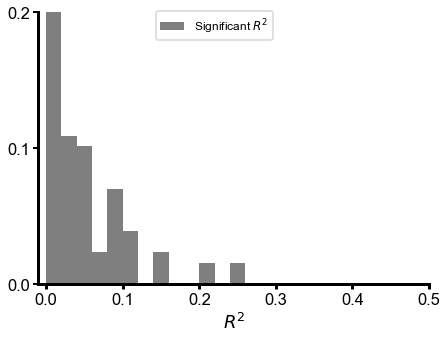

In [613]:
model_dt=.05
# for model_dt in [.025,.05,.1]:
# GLM_Vis_shuff = ioh5.load(save_dir/'GLM_{}_Data_Mov_dt{:03d}_T{:02d}_MovModel{:d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag, MovModel))
GLM_mot = ioh5.load(save_datafile)
locals().update(GLM_mot)
max_shuff = np.max(GLM_Vis_shuff['r2_all']**2)
fig,ax = plt.subplots(1,1,figsize=(7,5))

# sig = r2_all[r2_all>max_shuff]
# non_sig = r2_all[r2_all<max_shuff]
hbins=.02
count,edges = np.histogram(GLM_mot['r2_all'],bins=np.arange(0,1,hbins))
# count_shuff,edges_shuff = np.histogram(non_sig,bins=np.arange(0,1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
# edges_mid_shuff = np.array([(edges_shuff[i]+edges_shuff[i+1])/2 for i in range(len(edges_shuff)-1)])
ax.bar(edges_mid, count/len(GLM_Vis['r2_all']),color='k',width=hbins,alpha=.5, label='Significant $R^2$')
# ax.bar(edges_mid_shuff, count_shuff/len(GLM_Vis['r2_all']),color='r',width=hbins,alpha=1, label='NonSignificant $R^2$')
ax.set_xlabel('$R^2$')
ax.set_yticks(np.arange(0,1,.1))
ax.set_yticklabels(np.round(np.arange(0,1,.1),decimals=3))
ax.set_xlim(-.01,.5)
ax.set_ylim(0,.2)
ax.legend(fontsize=12,loc=(.3,.9))

# Pytorch Testing

In [964]:
input_size = xtr.shape[1]
output_size = 1#ytr.shape[1]
Nbatches = 5000
lossfn = torch.nn.PoissonNLLLoss(log_input=True,reduction='mean')

sps_train = train_nsp[:,celln]
sps_test = test_nsp[:,celln]
lambdas = np.arange(1,10)
# lambdas = 2**np.arange(0,18)# np.concatenate((np.arange(.1,1,.1),
alphas = np.array([1]) #np.arange(.01,.5,.05)
nlam = len(lambdas)
nalph = len(alphas)
# Initialze mse traces for regularization cross validation
msetrain = np.zeros((nlam,1))
msetest = np.zeros((nlam,1))
pred_all =np.zeros((x_test.shape[0],nlam)) 
w_cv = np.zeros((x_train.shape[-1],nlam))
w_intercept = np.zeros((nlam,1))
l1 = myLinear(input_size,output_size).to(device)
tloss_trace_all = np.zeros((nlam,Nbatches))
vloss_trace_all = np.zeros((nlam,Nbatches))
# loop over regularization strength
for l in (range(len(lambdas))):
    l1.reset_parameters()
    early_stopping = EarlyStopping()
    optimizer = optim.SGD(lr=.0001,params=l1.parameters(), weight_decay=0)#lambdas[l]) #
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.0001)
    vloss_trace = np.zeros(Nbatches)      
    tloss_trace = np.zeros(Nbatches)      
    early_stopping = EarlyStopping(patience=100,min_delta=.0005)
    for batchn in tqdm(np.arange(Nbatches)):
        out = l1(xtr)
        loss = lossfn(out,ytr) + lambdas[l]*(torch.linalg.norm(l1.weight))
        pred = l1(xte)
        val_loss = lossfn(pred,yte) + lambdas[l]*(torch.linalg.norm(l1.weight))
        vloss_trace[batchn] = val_loss.item()
        tloss_trace[batchn] = loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        early_stopping(val_loss.item())
        if early_stopping.early_stop:
            break
    tloss_trace_all[l] = tloss_trace
    vloss_trace_all[l] = vloss_trace
    w_cv[:,l] = l1.weight.clone().cpu().detach().numpy()
    w_intercept[l] = l1.bias.clone().cpu().detach().numpy()
    pred_all[:,l] = l1(xte).clone().cpu().detach().numpy().squeeze()
    # calculate test and training rms error
    msetrain[l] = np.mean((sps_train - np.exp(x_train@w_cv[:,l]))**2)
    msetest[l] = np.mean((sps_test - np.exp(x_test@w_cv[:,l]))**2)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
msetest[msetest!=np.nan],best_lambda

In [ ]:
# select best cross-validated lambda for RF
best_lambda = np.nanargmin(msetest[msetest!=np.nan])
w = w_cv.reshape(w_cv.shape[0],-1)[:,best_lambda]
# intercept= w_intercept[best_lambda]
sta_all = np.reshape(w,(nt_glm_lag,)+nks)
sp_pred = pred_all.reshape(pred_all.shape[0],-1)[:,best_lambda]

In [829]:
msetrain

array([[0.84822036],
       [0.84807403],
       [0.84819517],
       [0.84862458],
       [0.84727273],
       [0.84838073],
       [0.84775357],
       [0.84829184],
       [0.84887574]])

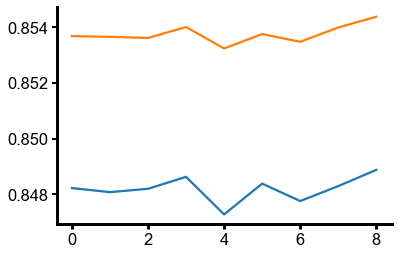

In [837]:
plt.plot(msetrain[:,0].T)
plt.plot(msetest[:,0].T)

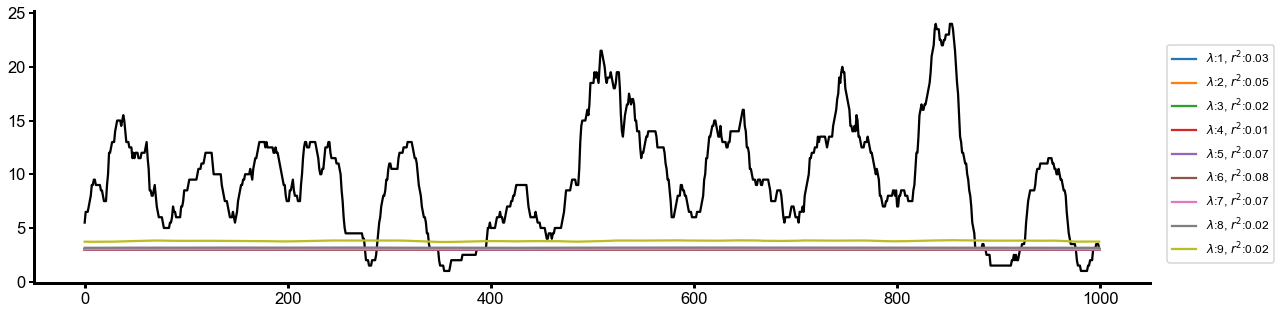

In [832]:
bin_length=40
t=0
dt=1000
fig,ax = plt.subplots(figsize=(20,5))
sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
ax.plot(sp_smooth[t:t+dt], 'k')
for n in range(pred_all.shape[-1]):
    pred_smooth = ((np.convolve(pred_all[:,n], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
    cc = (np.corrcoef(sp_smooth,pred_smooth)[0,1])**2
    ax.plot(pred_smooth[t:t+dt],label='$\lambda$:{}, $r^2$:{:.02f}'.format(lambdas[n],cc))
ax.legend(bbox_to_anchor=(1.01, .9), fontsize=12)



(55239.0234375, 0.0)

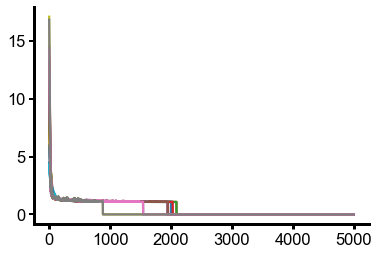

In [834]:
# for loss_trace in loss_trace_all:
# vloss_trace_all[loss_trace_all==0]=np.nan
plt.plot(tloss_trace_all.T)
plt.plot(vloss_trace_all.T)
loss_trace[0],loss_trace[-1]

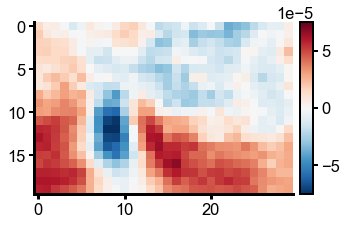

In [835]:
# w_all = l1.weight.cpu().clone().detach().numpy() # W
# w_all = W.cpu().clone().detach().numpy() # W

# sta_all = w_all.reshape(-1,nt_glm_lag,20,30)
crange = np.max(np.abs(sta_all))
fig,ax = plt.subplots(1,1,figsize=(5,5))
im=ax.imshow(sta_all[0],'RdBu_r',vmin=-crange,vmax=crange)
cbar = add_colorbar(im)

In [29]:
sta_cv = w_cv.T.reshape(nalph,nlam,20,30)

In [54]:
input_size = xtr.shape[1]
output_size = 1#ytr.shape[1]
Nbatches=5000
lossfn = torch.nn.PoissonNLLLoss(log_input=True,reduction='sum')

sps_train = train_nsp[:,celln]
sps_test = test_nsp[:,celln]
lambdas = 1024 * (2**np.arange(0,16))
# lambdas = 2**np.arange(0,18)# np.concatenate((np.arange(.1,1,.1),
alphas = np.array([1]) #np.arange(.01,.5,.05)
nlam = len(lambdas)
nalph = len(alphas)
# Initialze mse traces for regularization cross validation
msetrain = np.zeros((nalph,nlam,1))
msetest = np.zeros((nalph,nlam,1))
pred_all =np.zeros((x_test.shape[0],nalph,nlam)) 
w_cv = np.zeros((x_train.shape[-1],nalph,nlam))
w_intercept = np.zeros((nalph,nlam,1))
l1 = myLinear(input_size,output_size).to(device)
loss_trace_all = np.zeros((nalph,nlam,Nbatches))
# loop over regularization strength
for a,alpha in enumerate(tqdm(alphas)):
    for l in (range(len(lambdas))):
        # l1 = nn.Linear(input_size,output_size).to(device)
        # b.requires_grad=True
        # optimizer = optim.AdamW(lr=.01,params=l1.parameters(),weight_decay=2) #[W,b]
        l1.reset_parameters()
        early_stopping = EarlyStopping()
        optimizer = optim.SGD(lr=.0001,params=l1.parameters(), weight_decay=0)#lambdas[l]) #
        # lossfn = nn.MSELoss(reduction='sum')

        loss_trace = np.zeros(Nbatches)
        for batchn in (np.arange(Nbatches)):
            out = l1(xtr)
    #         loss = torch.mean(2*(ytr*torch.log(ytr/out) + out + ytr)) + alpha*torch.sum(torch.abs(l1.weight)) + (1-alpha)*lambdas[l]*torch.sum(torch.norm(l1.weight))
    #         print(loss.item())
            loss = lossfn(out,ytr) + (1-alpha)*torch.sum(torch.abs(l1.weight)) + alpha*lambdas[l]*torch.norm(l1.weight)
            loss_trace[batchn] = loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            early_stopping(loss.item())
            if early_stopping.early_stop:
                break
        loss_trace_all[a,l] = loss_trace
        w_cv[:,a,l] = l1.weight.clone().cpu().detach().numpy()
        w_intercept[a,l] = l1.bias.clone().cpu().detach().numpy()
        pred_all[:,a,l] = l1(xte).clone().cpu().detach().numpy().squeeze()
        # calculate test and training rms error
#         msetrain[a,l] = mean_poisson_deviance(sps_train,l1(xtr).clone().cpu().detach().numpy()) #np.mean((sps_train - model.predict(x_train))**2)
#         msetest[a,l] = mean_poisson_deviance(sps_test,pred_all[:,a,l]) # np.mean((sps_test - model.predict(x_test))**2)

  0%|          | 0/1 [00:00<?, ?it/s]

TypeError: poisson_nll_loss(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

# By hand Poisson GLM 

In [6]:
celln = 117

bin_length=40
nt_glm_lag = 5
stat_bins = 5
# minlag = int(-lag//(1000*model_dt)); maxlag=int((lag//(1000*model_dt))+1)
lag_list = np.array([0]) #np.array([-1,0,1,2,3]) #,np.arange(minlag,maxlag,np.floor((maxlag-minlag)/nt_glm_lag).astype(int))
nt_glm_lag = len(lag_list)

data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=False, do_norm=True,free_move=free_move, has_imu=free_move, has_mouse=False)
locals().update(data)
##### Explore Neurons #####
# Initialize movement combinations
titles = np.array(['Theta','Phi','Roll','Pitch']) # 'dg_p','dg_n' 'roll','pitch'
titles_all = []
for n in range(1,len(titles)+1):
    perms = np.array(list(itertools.combinations(np.arange(len(titles)), n)))
    for ind in range(perms.shape[0]):
        titles_all.append('_'.join([t for t in titles[perms[ind]]]))

# train_dgaze_p = train_dth + np.diff(train_gz,append=0)
# train_dgaze_n = train_dth - np.diff(train_gz,append=0)
# test_dgaze_p = test_dth + np.diff(test_gz,append=0)
# test_dgaze_n = test_dth - np.diff(test_gz,append=0)
move_train = np.hstack((train_th[:,np.newaxis],train_phi[:,np.newaxis],train_roll[:,np.newaxis],train_pitch[:,np.newaxis]))
move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_roll[:,np.newaxis],test_pitch[:,np.newaxis])) #,test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))#
# move_test = np.hstack((test_th[:,np.newaxis],test_phi[:,np.newaxis],test_dgaze_p[:,np.newaxis],test_dgaze_n[:,np.newaxis]))# test_dth[:,np.newaxis],test_dphi[:,np.newaxis]))
move_train = move_train - np.mean(move_train, axis=0)
move_test = move_test - np.mean(move_test,axis=0)


##### Format data #####
# save shape of train_data for initialization
nks = np.shape(model_vid_sm)[1:]; nk = nks[0]*nks[1]*nt_glm_lag

# Shift spikes by -lag for GLM fits
sps_train = np.roll(train_nsp[:,celln],-lag)
sps_test = np.roll(test_nsp[:,celln],-lag)

# Initialize saving movement weights 
w_move = np.zeros(move_train.shape[1])

# Take combination of movements
move_train = move_train[:,perms]
move_test = move_test[:,perms]

# Reshape data (video) into (T*n)xN array
x_train = train_vid.reshape(train_vid.shape[0],-1)
# x_train0 = np.ones((x_train.shape[0],1))
x_train = np.concatenate((x_train,np.ones((x_train.shape[0],1))),axis=1)

# x_train = np.hstack([np.roll(x_train, nframes, axis=0) for nframes in reversed(range(nt_glm_lag))])
# x_train = np.append(x_train, np.ones((x_train.shape[0],1)), axis=1) # append column of ones for fitting intercept
# move_train = np.hstack([np.roll(move_train,nframes, axis=0) for nframes in reversed(range(nt_glm_lag))])
# x_train = np.concatenate((x_train, move_train),axis=1)

x_test = test_vid.reshape(test_vid.shape[0],-1) 
# x_test0 = np.ones((x_test.shape[0],1))
x_test = np.concatenate((x_test,np.ones((x_test.shape[0],1))),axis=1)

# x_test = np.hstack([np.roll(x_test,nframes, axis=0) for nframes in reversed(range(nt_glm_lag))])
# x_test = np.append(x_test,np.ones((x_test.shape[0],1)), axis=1) # append column of ones
# move_test = np.hstack([np.roll(move_test,nframes, axis=0) for nframes in reversed(range(nt_glm_lag))])
# x_test = np.concatenate((x_test, move_test),axis=1)

# Prepare Design Matrix
lambdas = 2**np.arange(10)
nlam = len(lambdas)
XXtr = x_train.T @ x_train
XYtr = x_train.T @ sps_train

Done Loading Aligned Data
TRAIN: 15628 TEST: 6698


NameError: name 'lag' is not defined

In [132]:
# Initialze mse traces for regularization cross validation
msetrain = np.zeros((nlam,1))
msetest = np.zeros((nlam,1))
w_ridge = np.zeros((x_train.shape[-1],nlam))
# Inverse matrix for regularization 
Cinv = np.eye(nk)
Cinv = linalg.block_diag(Cinv,np.zeros((1, 1)))
# loop over regularization strength
for l in range(len(lambdas)):  
    # calculate MAP estimate               
    w = np.linalg.solve(XXtr + lambdas[l]*Cinv, XYtr) # equivalent of \ (left divide) in matlab
    w_ridge[:,l] = w
    # calculate test and training rms error
    msetrain[l] = np.mean((sps_train - x_train@w)**2)
    msetest[l] = np.mean((sps_test - x_test@w)**2)

In [636]:
# functions for poisson fit
def costFun(prs,XX,YY,Cinv,dt):
    vv = XX@prs; #filter output
    rr = np.exp(vv)*dt; # conditional intensity (per bin)

    # ---------  Compute log-likelihood -----------
    Trm1 = -vv.T@YY; # spike term from Poisson log-likelihood
    Trm0 = sum(rr);  # non-spike term 
    neglogli = Trm1 + Trm0  + .5*prs.T@Cinv@prs;   
    
    dL1 = -XX.T@YY; # spiking term (the spike-triggered average)
    dL0 = XX.T@rr; # non-spiking term
    dL = dL1+dL0;   
    
    g = dL + Cinv@prs
    return (neglogli,g)

def hessfun(prs,XX,YY,Cinv,dt):
    vv = XX@prs; #filter output
    rr = np.exp(vv)*dt; # conditional intensity (per bin)  
    H = XX.T@(XX.T*rr).T + Cinv; 
    return H

In [ ]:

def hessfun2(prs,XX,YY,Cinv,dt):
    vv = XX@prs; #filter output
    rr = np.exp(vv)*dt; # conditional intensity (per bin)  
    H = XX.T@(XX.T*rr).T + Cinv; 
    return H

In [660]:
lambdas = 1024 * (2**np.arange(0,16))
model = lm.RidgeCV(alphas=lambdas)
model.fit(x_train,sps_train)

RidgeCV(alphas=array([    1024,     2048,     4096,     8192,    16384,    32768,
          65536,   131072,   262144,   524288,  1048576,  2097152,
        4194304,  8388608, 16777216, 33554432]))

In [661]:
best_lambda = np.where(lambdas==model.alpha_)[0]

In [680]:
w = x_train.T@sps_train/np.sum(sps_train)
Imat = np.eye(nk);
Imat = linalg.block_diag(Imat,np.zeros((1,1)))
w_cv = np.zeros((len(lambdas),w.shape[0]))
msetrain = np.zeros((nlam,1))
msetest = np.zeros((nlam,1)
for l in trange(len(lambdas)):
    poiss_sta = minimize(fun = costFun, method = 'dogleg', x0=w, args = (x_train, sps_train, lambdas[l]*Imat,1), jac = True, hess=hessfun,options={'disp': False})
    w_cv[l] = poiss_sta.x
    msetrain[l] = np.mean((sps_train - np.exp(x_train@poiss_sta.x))**2)
    msetest[l] = np.mean((sps_test - np.exp(x_test@poiss_sta.x))**2)

  0%|          | 0/16 [00:00<?, ?it/s]

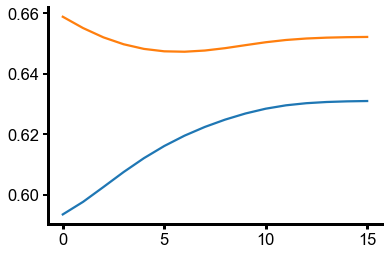

In [682]:
plt.plot(msetrain)
plt.plot(msetest)

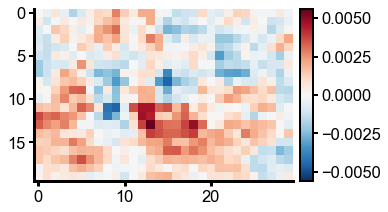

In [683]:
sta = w_cv[np.argmin(msetest)]
crange = np.max(np.abs(sta[:nk]))
fig,ax = plt.subplots(1,1,figsize=(5,5))
im=ax.imshow(sta[:nk].reshape(nks),'RdBu_r',vmin=-crange,vmax=crange)
cbar = add_colorbar(im)

In [674]:
celln = 25
lag_list =  np.array([-1,0,1,2,3]) #,np.arange(minlag,maxlag,np.floor((maxlag-minlag)/nt_glm_lag).astype(int))
nt_glm_lag = len(lag_list)
# print(lag_list,1000*lag_list*model_dt)
do_shuffle=False
model_type = 'poissonregressor'
# perms = np.array(list(itertools.combinations(np.arange(len(titles)), 1)))
# perm = perms[0]
##### Start GLM Parallel Processing #####
start = time.time()
nks = np.shape(train_vid)[1:]; nk = nks[0]*nks[1]

msta = np.zeros(((len(lag_list),)+nks))
# Reshape data (video) into (T*n)xN array
for lagn,lag in enumerate(lag_list):
    rolled_vid = np.roll(model_vid_sm, lag, axis=0)
    x = rolled_vid.reshape(model_vid_sm.shape[0],-1)
    sp = model_nsp[:,celln].copy()
#     sp = np.roll(sp, -lag)
    sta = x.T @ sp
    sta = np.reshape(sta, nks)
    nsp = np.sum(sp)
    if nsp > 0:
        sta = sta/nsp
    else:
        sta = np.nan
    msta[lagn] = sta
    
    


In [675]:
sta = XYtr/np.sum(sps_train); # compute STA for initialization
# rolled_vid = np.roll(model_vid_sm, lag, axis=0)
# x = rolled_vid.reshape(model_vid_sm.shape[0],-1)
# sp = model_nsp[:,celln].copy()
# #     sp = np.roll(sp, -lag)
# sta = x.T @ sp
# sta = np.reshape(sta, nks)
# nsp = np.sum(sp)
# if nsp > 0:
#     sta = sta/nsp

In [676]:
w = XYtr/np.sum(sps_train)

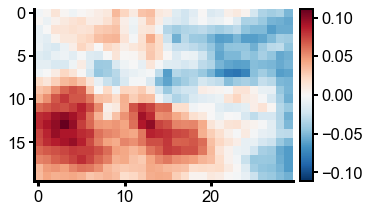

In [677]:
crange = np.max(np.abs(sta[:nk]))
fig,ax = plt.subplots(1,1,figsize=(5,5))
im=ax.imshow(sta[:nk].reshape(nks),'RdBu_r',vmin=-crange,vmax=crange)
cbar = add_colorbar(im)

In [143]:
w.shape,x_train.shape, sta.shape

((601,), (15628, 601), (601,))

In [151]:
negLP,grad,H = neglogli_poissGLM(w,x_train,sps_train)

# negLP = negLP + .5*w.T@Cinv@w;        
# grad = grad + Cinv*w;
# H = H + Cinv;

In [166]:
from scipy.special import expit

In [244]:
def qu(z):
    """The non-linearity."""
    return np.log1p(np.exp(z))

def lmb(self, beta, X):
    """Conditional intensity function."""
    beta0 = beta[-1:]
    beta = beta[:-1]
    z = beta0 + np.dot(X, beta)
    l = qu(z)
    return l

def penalty(alpha, beta):
    """the penalty term"""
    P = 0.5 * (1 - alpha) * np.linalg.norm(beta, 2)**2 + alpha*np.linalg.norm(beta, 1)
    return P

def loss(beta, reg_lambda, X, y):
    """Define the objective function for elastic net."""
    L = grad_L2loss(beta,reg_lambda, X, y)
    return L

def L2loss(beta,alpha, reg_lambda, X, y):
    beta0 = beta[-1:]
    beta = beta[:-1]
    z = beta0 + np.dot(X, beta)
    s = expit(z)
    q = qu(z)
    grad_beta0 = np.sum(s) - np.sum(y * s / q)
    grad_beta = np.transpose(np.dot(np.transpose(s), X) - np.dot(np.transpose(y * s / q), X)) + reg_lambda * (1 - alpha) * beta
#     return np.hstack((grad_beta,grad_beta0))
    return np.mean(np.hstack((grad_beta,grad_beta0)))

def grad_L2loss(beta,alpha, reg_lambda, X, y):
    beta0 = beta[-1:]
    beta = beta[:-1]
    z = beta0 + np.dot(X, beta)
    s = expit(z)
    q = qu(z)
    grad_beta0 = np.sum(s) - np.sum(y * s / q)
    grad_beta = np.transpose(np.dot(np.transpose(s), X) - np.dot(np.transpose(y * s / q), X)) + reg_lambda * (1 - alpha) * beta
#     return np.hstack((grad_beta,grad_beta0))
    return np.hstack((grad_beta,grad_beta0))

def hessian_loss(beta, alpha, reg_lambda, X, y):
    beta0 = beta[-1:]
    beta = beta[:-1]
    z = beta0 + np.dot(X, beta)
    q = qu(z)
    s = expit(z)
    grad_s = s * (1-s)
    grad_s_by_q = grad_s/q - s/(q * q)
    hess_beta0 = np.sum(grad_s) - np.sum(y * grad_s_by_q)
    hess_beta = np.transpose(np.dot(np.transpose(grad_s), X * X)- np.dot(np.transpose(y * grad_s_by_q), X * X)) + reg_lambda * (1-alpha)
    return np.hstack((hess_beta, hess_beta0))


In [247]:
reg_lambda = .1
alpha = .5
res = minimize(L2loss,sta,method='dogleg', args=(alpha,reg_lambda,x_train,sps_train),jac=grad_L2loss,hess=hessian_loss)

ValueError: Input array is expected to be square but has the shape: (1, 601).

# StatsModel

In [11]:
import statsmodels.api as sm

In [ ]:
df = pd.DataFrame({'spks':model_nsp[:,celln],

In [417]:
sps_train = train_nsp[:,celln]
sps_test = test_nsp[:,celln]

lambdas = np.arange(0,.022,.002)

nlam = len(lambdas)
# Initialze mse traces for regularization cross validation
msetrain = np.zeros((nlam,1))
msetest = np.zeros((nlam,1))
pred_all =np.zeros((x_test.shape[0],nlam)) 
w_cv = np.zeros((x_train.shape[-1],nlam))
w_intercept = np.zeros((nlam,1))
                        
# loop over regularization strength
alpha = .1
model = sm.GLM(train_nsp[:,celln],x_train, family=sm.families.Poisson())
for l in tqdm(range(len(lambdas))):

    results = model.fit_regularized(alpha=.001,L1_wt=.1,cnvrg_tol=.0001,maxiter=100)
                        
    
    w_cv[:,l] = results.params
#     w_intercept[l] = l1.bias.clone().cpu().detach().numpy()
    pred_all[:,l] = results.predict(x_test)
    # calculate test and training rms error
    msetrain[l] = mean_poisson_deviance(sps_train,results.predict(x_train)) #np.mean((sps_train - model.predict(x_train))**2)
    msetest[l] = mean_poisson_deviance(sps_test,pred_all[:,l]) # np.mean((sps_test - model.predict(x_test))**2)
# select best cross-validated lambda for RF
best_lambda = np.argmin(msetest)
w = w_cv[:,best_lambda]
intercept= w_intercept[best_lambda]
sta_all = np.reshape(w,(nt_glm_lag,)+nks)
sp_pred = pred_all[:,best_lambda]


  0%|          | 0/11 [00:00<?, ?it/s]

/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1323: UserWarning: Elastic net fitting did not converge
  warnings.warn("Elastic net fitting did not converge")
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1323: UserWarning: Elastic net fitting did not converge
  warnings.warn("Elastic net fitting did not converge")
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1323: UserWarning: Elastic net fitting did not converge
  warnings.warn("Elastic net fitting did not converge")
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1323: UserWarning: Elastic net fitting did not converge
  warnings.warn("Elastic net fitting did not converge")
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:13

In [192]:
start = time.time()

model = sm.GLM(train_nsp[:,celln],x_train, family=sm.families.Poisson())
results = model.fit_regularized(alpha=.001,L1_wt=.2,cnvrg_tol=.0001)

print('GLM: ', time.time()-start)


GLM:  348.33977603912354


/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/statsmodels/genmod/generalized_linear_model.py:1323: UserWarning: Elastic net fitting did not converge
  warnings.warn("Elastic net fitting did not converge")


In [418]:
ypred = results.predict(x_test)

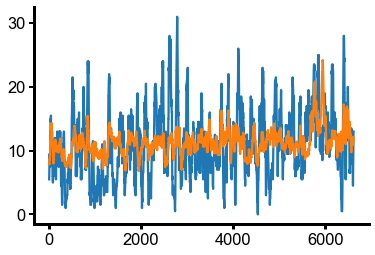

In [420]:
bin_length=40
# celln=0
# pred_smooth = ((np.convolve(pred_sp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
pred_smooth = ((np.convolve(sp_pred, np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
sp_smooth = ((np.convolve(test_nsp[:,celln], np.ones(bin_length), 'same')) / (bin_length * model_dt))[bin_length:-bin_length]
plt.plot(sp_smooth)
plt.plot(pred_smooth)

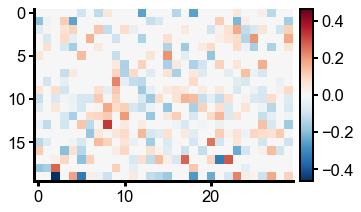

In [421]:
# print(results.summary())
w = results.params
sta = w.reshape(20,30)
crange = np.max(np.abs(w))
fig,ax = plt.subplots(1,1,figsize=(5,5))
im=ax.imshow(sta,'RdBu_r',vmin=-crange,vmax=crange)
cbar = add_colorbar(im)

# ProbFlow Testing

In [699]:
import probflow as pf
pf.set_backend('pytorch') #or 'tensorflow'

class PoissonRegression(pf.DiscreteModel):

    def __init__(self, dims):
        self.w = pf.Parameter([dims, 1], name='Weights')
        self.b = pf.Parameter([1, 1], name='Bias')
        
#         self.lam = pf.Parameter([1,1], name='lambda')
#         self.alpha = pf.Parameter([1,1], name='alpha')

    def __call__(self, x):
        x = torch.tensor(x)
#         print(pf.Poisson(torch.exp(x @ self.w() + self.b())))#,(1-self.alpha)*self.lam*torch.norm(self.w),self.alpha*(torch.sum(torch.abs(self.w))))
        return pf.Poisson(torch.exp(x @ self.w() + self.b())) #+ (1-self.alpha)*self.lam*torch.norm(self.w) + self.alpha*(torch.sum(torch.abs(self.w)))

In [700]:
lag=150 # in ms
nt_glm_lag = 5
# minlag = int(-lag//(1000*model_dt)); maxlag=int((lag//(1000*model_dt))+1)
lag_list = np.array([-1,0,1,2,3]) #,np.arange(minlag,maxlag,np.floor((maxlag-minlag)/nt_glm_lag).astype(int))
nt_glm_lag = len(lag_list)
print(lag_list,1000*lag_list*model_dt)
do_shuffle=False
model_type = 'poissonregressor'


# for do_shuffle in [False,True]:
# Load Data
data, train_idx, test_idx = load_train_test(file_dict, save_dir, model_dt=model_dt, do_shuffle=do_shuffle, do_norm=True,free_move=free_move, has_imu=free_move, has_mouse=False)
locals().update(data)

##### Start GLM Parallel Processing #####
nks = np.shape(train_vid)[1:]; nk = nks[0]*nks[1]*nt_glm_lag
# Reshape data (video) into (T*n)xN array
#     x_train = train_vid.reshape(train_vid.shape[0],-1)
#     x_train = np.hstack([np.roll(x_train, nframes, axis=0) for nframes in lag_list]) # nt_glm_lag
#     x_test = test_vid.reshape(test_vid.shape[0],-1) 
#     x_test = np.hstack([np.roll(x_test, nframes, axis=0) for nframes in lag_list])#
rolled_vid = np.hstack([np.roll(model_vid_sm, nframes, axis=0) for nframes in lag_list]) # nt_glm_lag
x_train = rolled_vid[train_idx].reshape(len(train_idx),-1)
x_test = rolled_vid[test_idx].reshape(len(test_idx),-1)


[-1  0  1  2  3] [-50.   0.  50. 100. 150.]
Done Loading Aligned Data
TRAIN: 15628 TEST: 6698


In [39]:
#     # Put data into shared memory for parallization 
#     num_ticks= (len(titles_all)*train_nsp.shape[-1])
#     pb = ProgressBar(num_ticks)
#     actor = pb.actor
#     train_nsp_r = ray.put(train_nsp)
#     test_nsp_r = ray.put(test_nsp)
#     train_data_r = ray.put(x_train)
#     test_data_r = ray.put(x_test)
#     result_ids = []
#     # Loop over parameters appending process ids
#     for celln in range(train_nsp.shape[1]):
#         result_ids.append(do_glm_fit_vis_skl.remote(train_nsp_r, test_nsp_r, train_data_r, test_data_r, celln, model_type, lag_list, actor, model_dt=model_dt))

#     print('N_proc:', len(result_ids))
#     pb.print_until_done()
#     results_p = ray.get(result_ids)
#     print('GLM: ', time.time()-start)

#     ##### Gather Data and Find Max CC Model #####
#     mcc = np.stack([results_p[i][0] for i in range(len(results_p))])
#     msta = np.stack([results_p[i][1] for i in range(len(results_p))])
#     msp = np.stack([results_p[i][2] for i in range(len(results_p))])
#     mpred = np.stack([results_p[i][3] for i in range(len(results_p))])
#     mr2 = np.stack([results_p[i][4] for i in range(len(results_p))])

#     nt_glm_lag = len(lag_list)
#     GLM_Data = {'mcc': mcc,
#                 'msta': msta,
#                 'msp': msp,
#                 'mpred': mpred,
#                 'mr2':mr2,}
#     if do_shuffle:
#         ioh5.save(save_dir/'GLM_{}_Data_VisOnly_notsmooth_dt{:03d}_T{:02d}_shuffled.h5'.format(model_type,int(model_dt*1000), nt_glm_lag), GLM_Data)
#     else:
#         ioh5.save(save_dir/'GLM_{}_Data_VisOnly_notsmooth_dt{:03d}_T{:02d}.h5'.format(model_type,int(model_dt*1000), nt_glm_lag), GLM_Data)
        
#     del train_nsp_r, test_nsp_r, train_data_r, test_data_r, result_ids, results_p, mcc, msta, msp, mpred, mr2,
#     gc.collect()

NameError: name 'titles_all' is not defined

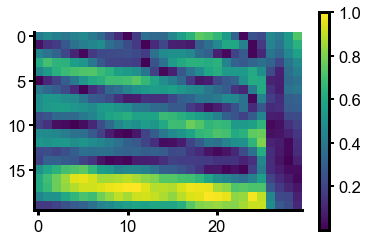

In [113]:
plt.imshow(model_vid_sm[0])
plt.colorbar()

In [ ]:
x_train.shape

In [707]:
model = PoissonRegression(x_train.shape[-1])

In [708]:
w = pf.Parameter([x_train.shape[-1], 1], name='Weights')
b = pf.Parameter([1, 1], name='Bias')

lam = pf.Parameter([1,1], name='lambda')
alpha = pf.Parameter([1,1], name='alpha')
x=torch.tensor(x_train,dtype=torch.float32)
# x @ w() + b()
# torch.exp(x @ w() + b())
pf.Poisson(torch.exp(x @ w() + b()))

In [711]:
model.fit(x_train.astype(np.float32),train_nsp[:,51].astype(np.float32),epochs=500,verbose=True)

TypeError: fit() got an unexpected keyword argument 'verbose'

In [704]:
pred = model.predict(x_test.astype(np.float32)) 

<ipython-input-699-223b92de5112>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


ValueError: The parameter loc has invalid values

In [ ]:
plt.plot(pred)
plt.plot(test_nsp[:,51])

In [97]:
w = model.w.variables['loc'].clone().detach().numpy()
w = w.reshape(5,20,30)

/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/seuss/anaconda3/envs/pytorch/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


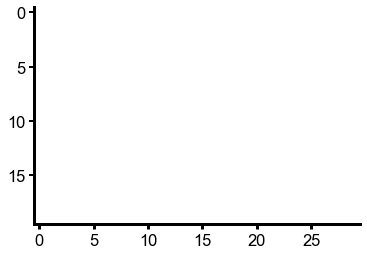

In [98]:
plt.imshow(w[0])